In [1]:
import csv
import subprocess
import shlex
import json

import numpy as np

from io import StringIO
from matplotlib import pyplot as plt
from scipy.stats import chisquare, kstest, norm, combine_pvalues
from IPython.display import display, Markdown
from tqdm import tqdm

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

def show():
    plt.savefig(f"non-spatial-coverage.{show.fig_counter}.pdf", dpi='figure', transparent=True, bbox_inches='tight')
    show.fig_counter += 1
    show.plt_show()

show.fig_counter = 0
show.plt_show = plt.show

plt.show = show

In [3]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

# Non-spatial Dispersal Coverage Test

In [4]:
def test_nonspatial_dispersal_coverage(
    algorithm, speciation=0.001, seeds=[42], size=100, sample=1.0
):
    total_pvalues = []
    total_locations = []
    
    for seed in tqdm(seeds):
        # Configure the simulation
        config = "".join("""
        (
            speciation: {speciation},
            seed: {seed},
            sample: {sample},

            algorithm: {algorithm}(),

            scenario: NonSpatial(
                area: ({size}, {size}),
                deme: {size},
            ),

            reporters: [
                Plugin(
                    library: "{target_directory}/release/deps/libnecsim_plugins_statistics.so",
                    reporters: [
                        GlobalCoverage(output: "{output_file}"),
                    ],
                ),
            ],
        )
        """.format(
            target_directory=target_directory, output_file="/dev/fd/2",
            algorithm=algorithm, speciation=speciation, seed=seed, sample=sample, size=size,
        ).split()).replace(",)", ")").replace(",]", "]")

        # Run the simulation
        locations_io = StringIO(subprocess.run(shlex.split(
            "cargo run --release --features rustcoalescence-algorithms-monolithic,"
            + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
        ), check=True, capture_output=True, text=True).stderr)

        # Read in the dispersal locations
        locations = []
        with locations_io:
            reader = csv.reader(locations_io)
            next(reader)

            for row in reader:
                locations.append((int(row[3]), int(row[4]), int(row[5])))
        locations = np.array(locations)

        # Calculate the goodness of fit of the dispersal coverage
        gof = chisquare(np.histogramdd(locations, bins=(
            range(0, size+1), range(0, size+1), range(0, size+1)
        ))[0].flatten())
        
        total_pvalues.append(gof.pvalue)
        total_locations.append(locations)
    
    gof_statistic, gof_pvalue = combine_pvalues(total_pvalues)
    
    if gof_pvalue <= 0.01 or gof_pvalue >= 0.99:
        display(Markdown(f"## <span style='color:purple'><u>{algorithm}</u></span>"))
    elif gof_pvalue <= 0.05 or gof_pvalue >= 0.95:
        display(Markdown(f"## <span style='color:red'><u>{algorithm}</u></span>"))
    elif gof_pvalue <= 0.1 or gof_pvalue >= 0.9:
        display(Markdown(f"## <span style='color:orange'>*{algorithm}*</span>"))
    else:
        display(Markdown(f"## <span style='color:green'>{algorithm}</span>"))
    
    display(Markdown("#### Fisher’s combined Chi-squared test:"))
    display(Markdown(f"* p-value: {gof_pvalue}\n* statistic: {gof_statistic}"))
    
    plt.title("Distribution of p-values")
    plt.xlabel("p")
    plt.ylabel("pdf")
    plt.hist(total_pvalues, density=True)
    plt.show()
    
    display(Markdown("#### Dispersal Histograms:"))
    
    locations = np.concatenate(total_locations)
    
    # Draw the 1d and 2d dispersal coverage histograms
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 10))
    
    ax1.set_title("Dispersal histogram x")
    ax1.set_xlabel("x")
    ax1.set_ylabel("pmf")
    ax1.hist(locations[:,0], bins=range(0, size+1), density=True)
    
    ax2.set_title("Dispersal histogram y")
    ax2.set_xlabel("y")
    ax2.set_ylabel("pmf")
    ax2.hist(locations[:,1], bins=range(0, size+1), density=True)
    
    ax3.set_title("Dispersal histogram index")
    ax3.set_xlabel("index")
    ax3.set_ylabel("pmf")
    ax3.hist(locations[:,2], bins=range(0, size+1), density=True)

    ax4.set_title("Dispersal histogram x-y")
    ax4.set_xlabel("x")
    ax4.set_ylabel("y")
    hist1 = ax4.hist2d(locations[:,0], locations[:,1],
                       bins=(range(0, size+1), range(0, size+1)),
                       density=True)
    fig.colorbar(hist1[3], ax=ax4)

    ax5.set_title("Dispersal histogram x-index")
    ax5.set_xlabel("x")
    ax5.set_ylabel("index")
    hist2 = ax5.hist2d(locations[:,0], locations[:,2],
                       bins=(range(0, size+1), range(0, size+1)),
                       density=True)
    fig.colorbar(hist2[3], ax=ax5)

    ax6.set_title("Dispersal histogram y-index")
    ax6.set_xlabel("y")
    ax6.set_ylabel("index")
    hist3 = ax6.hist2d(locations[:,1], locations[:,2],
                       bins=(range(0, size+1), range(0, size+1)),
                       density=True)
    fig.colorbar(hist3[3], ax=ax6)

    plt.show()
    
    display(Markdown(f"#### Parameters:\n* seeds: {seeds}"))
    
    display(Markdown(f"#### Configuration:\n```rust\n{config}\n```"))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:36<00:00,  1.94it/s]


## <span style='color:green'>Classical</span>

#### Fisher’s combined Chi-squared test:

* p-value: 0.24143148176413579
* statistic: 2044.0333402734057

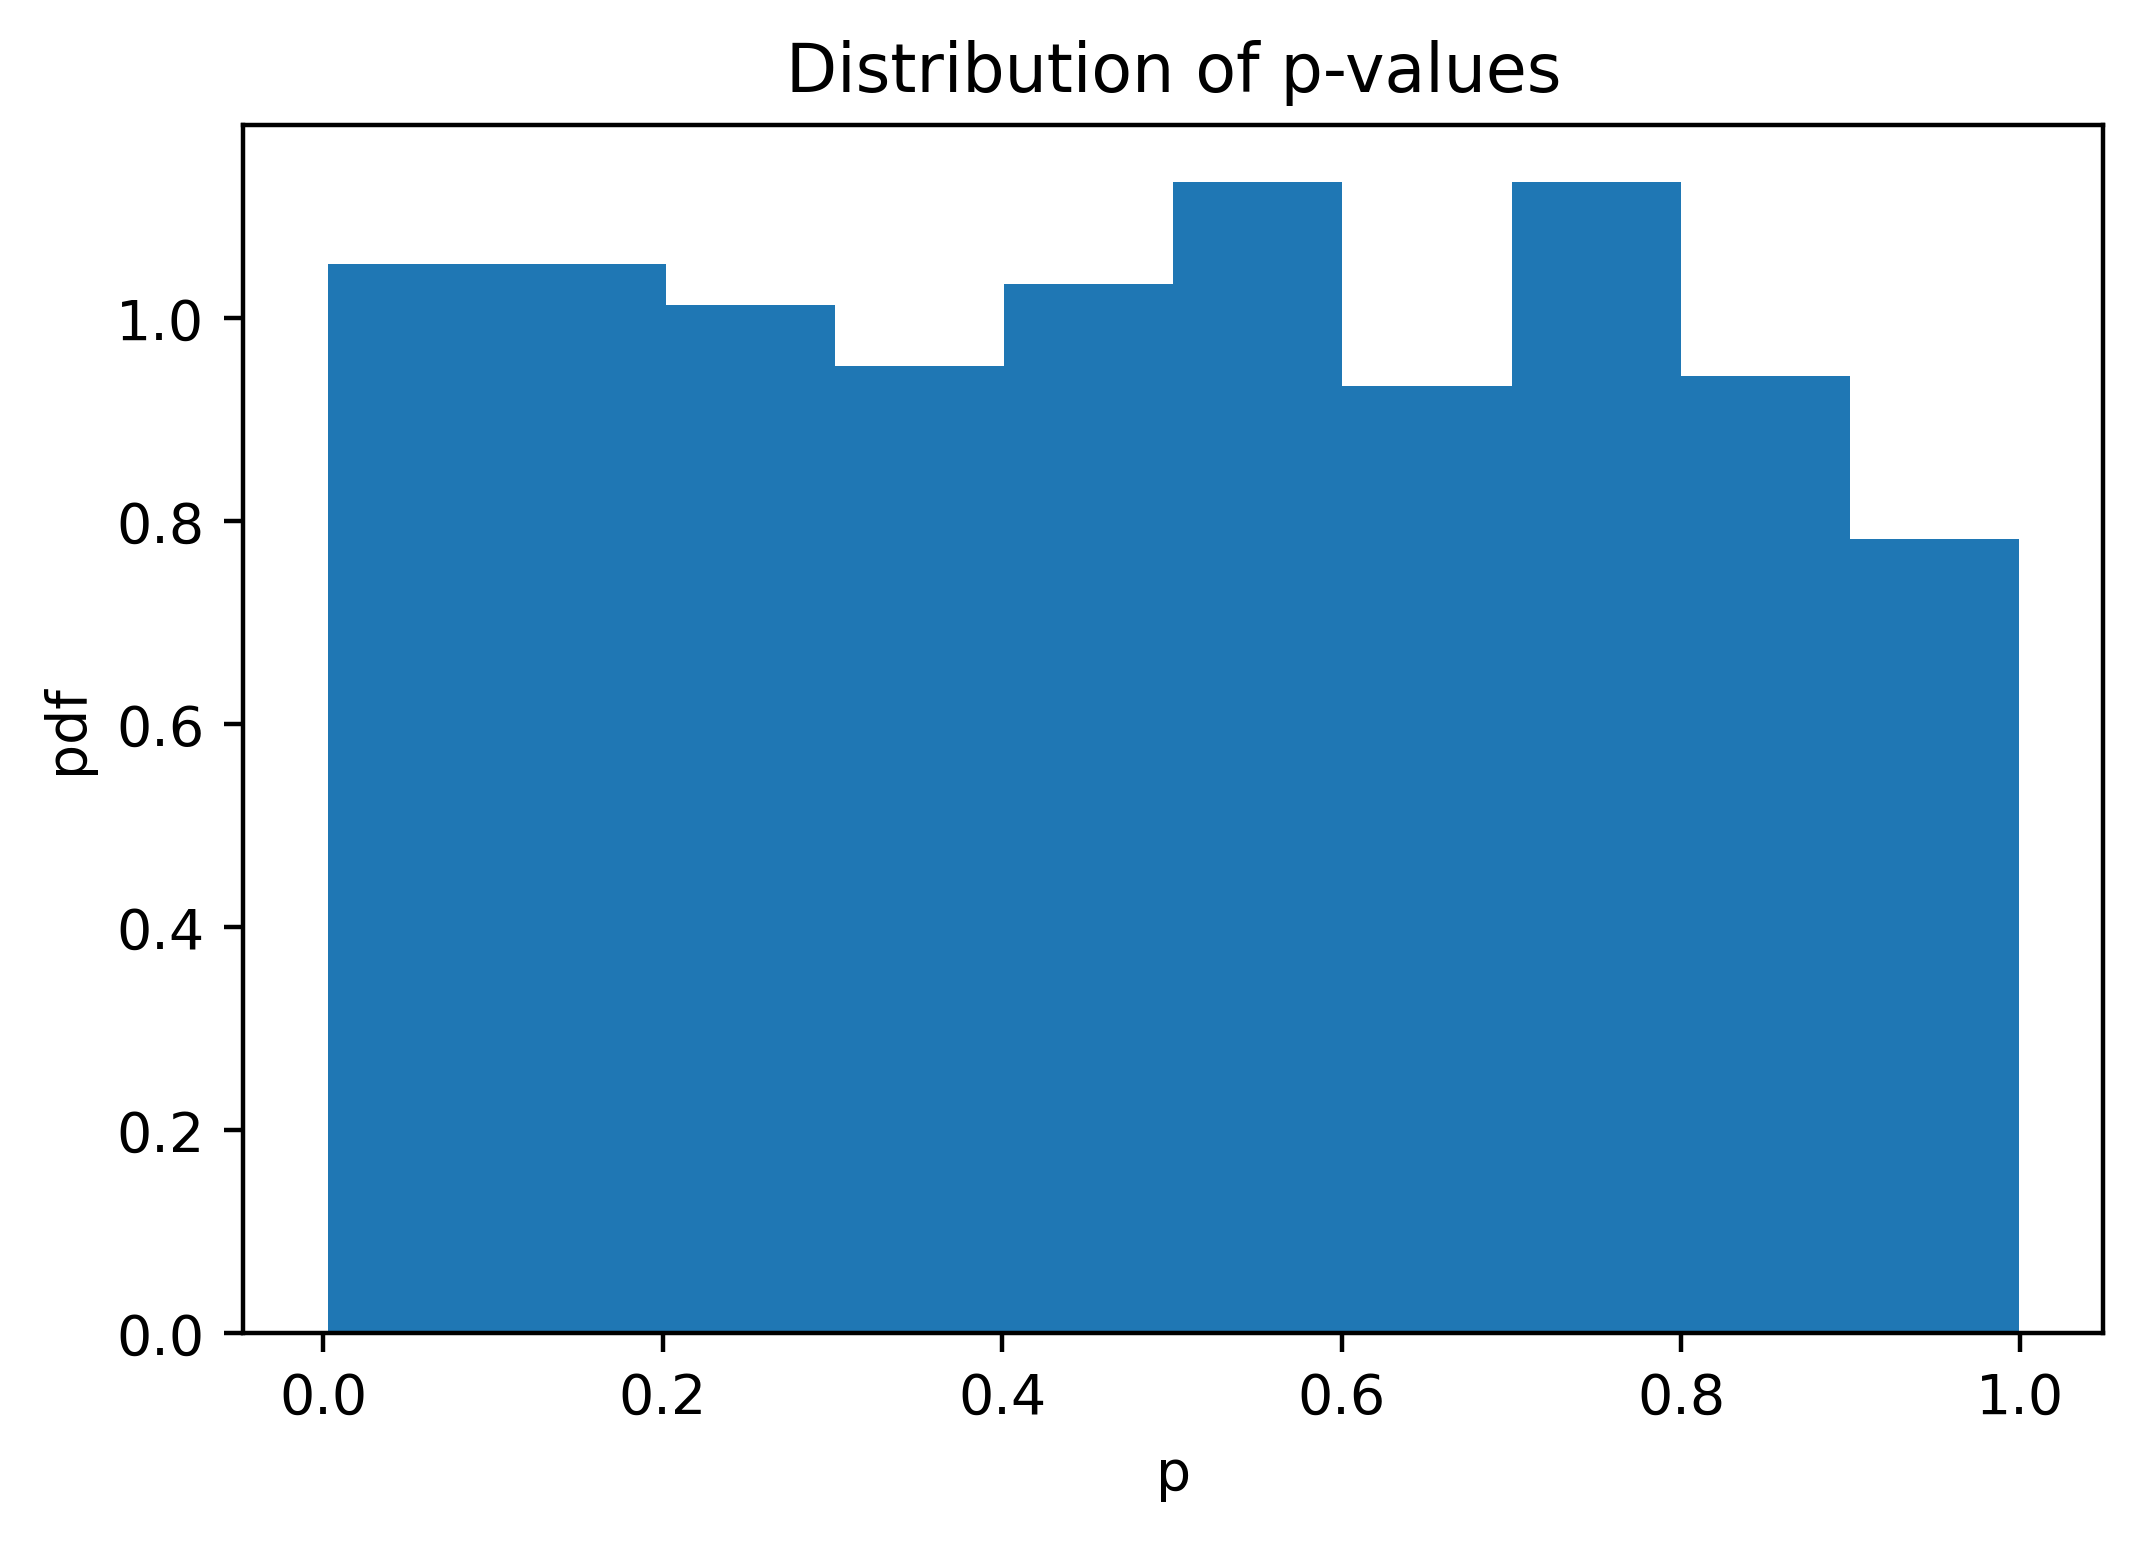

#### Dispersal Histograms:

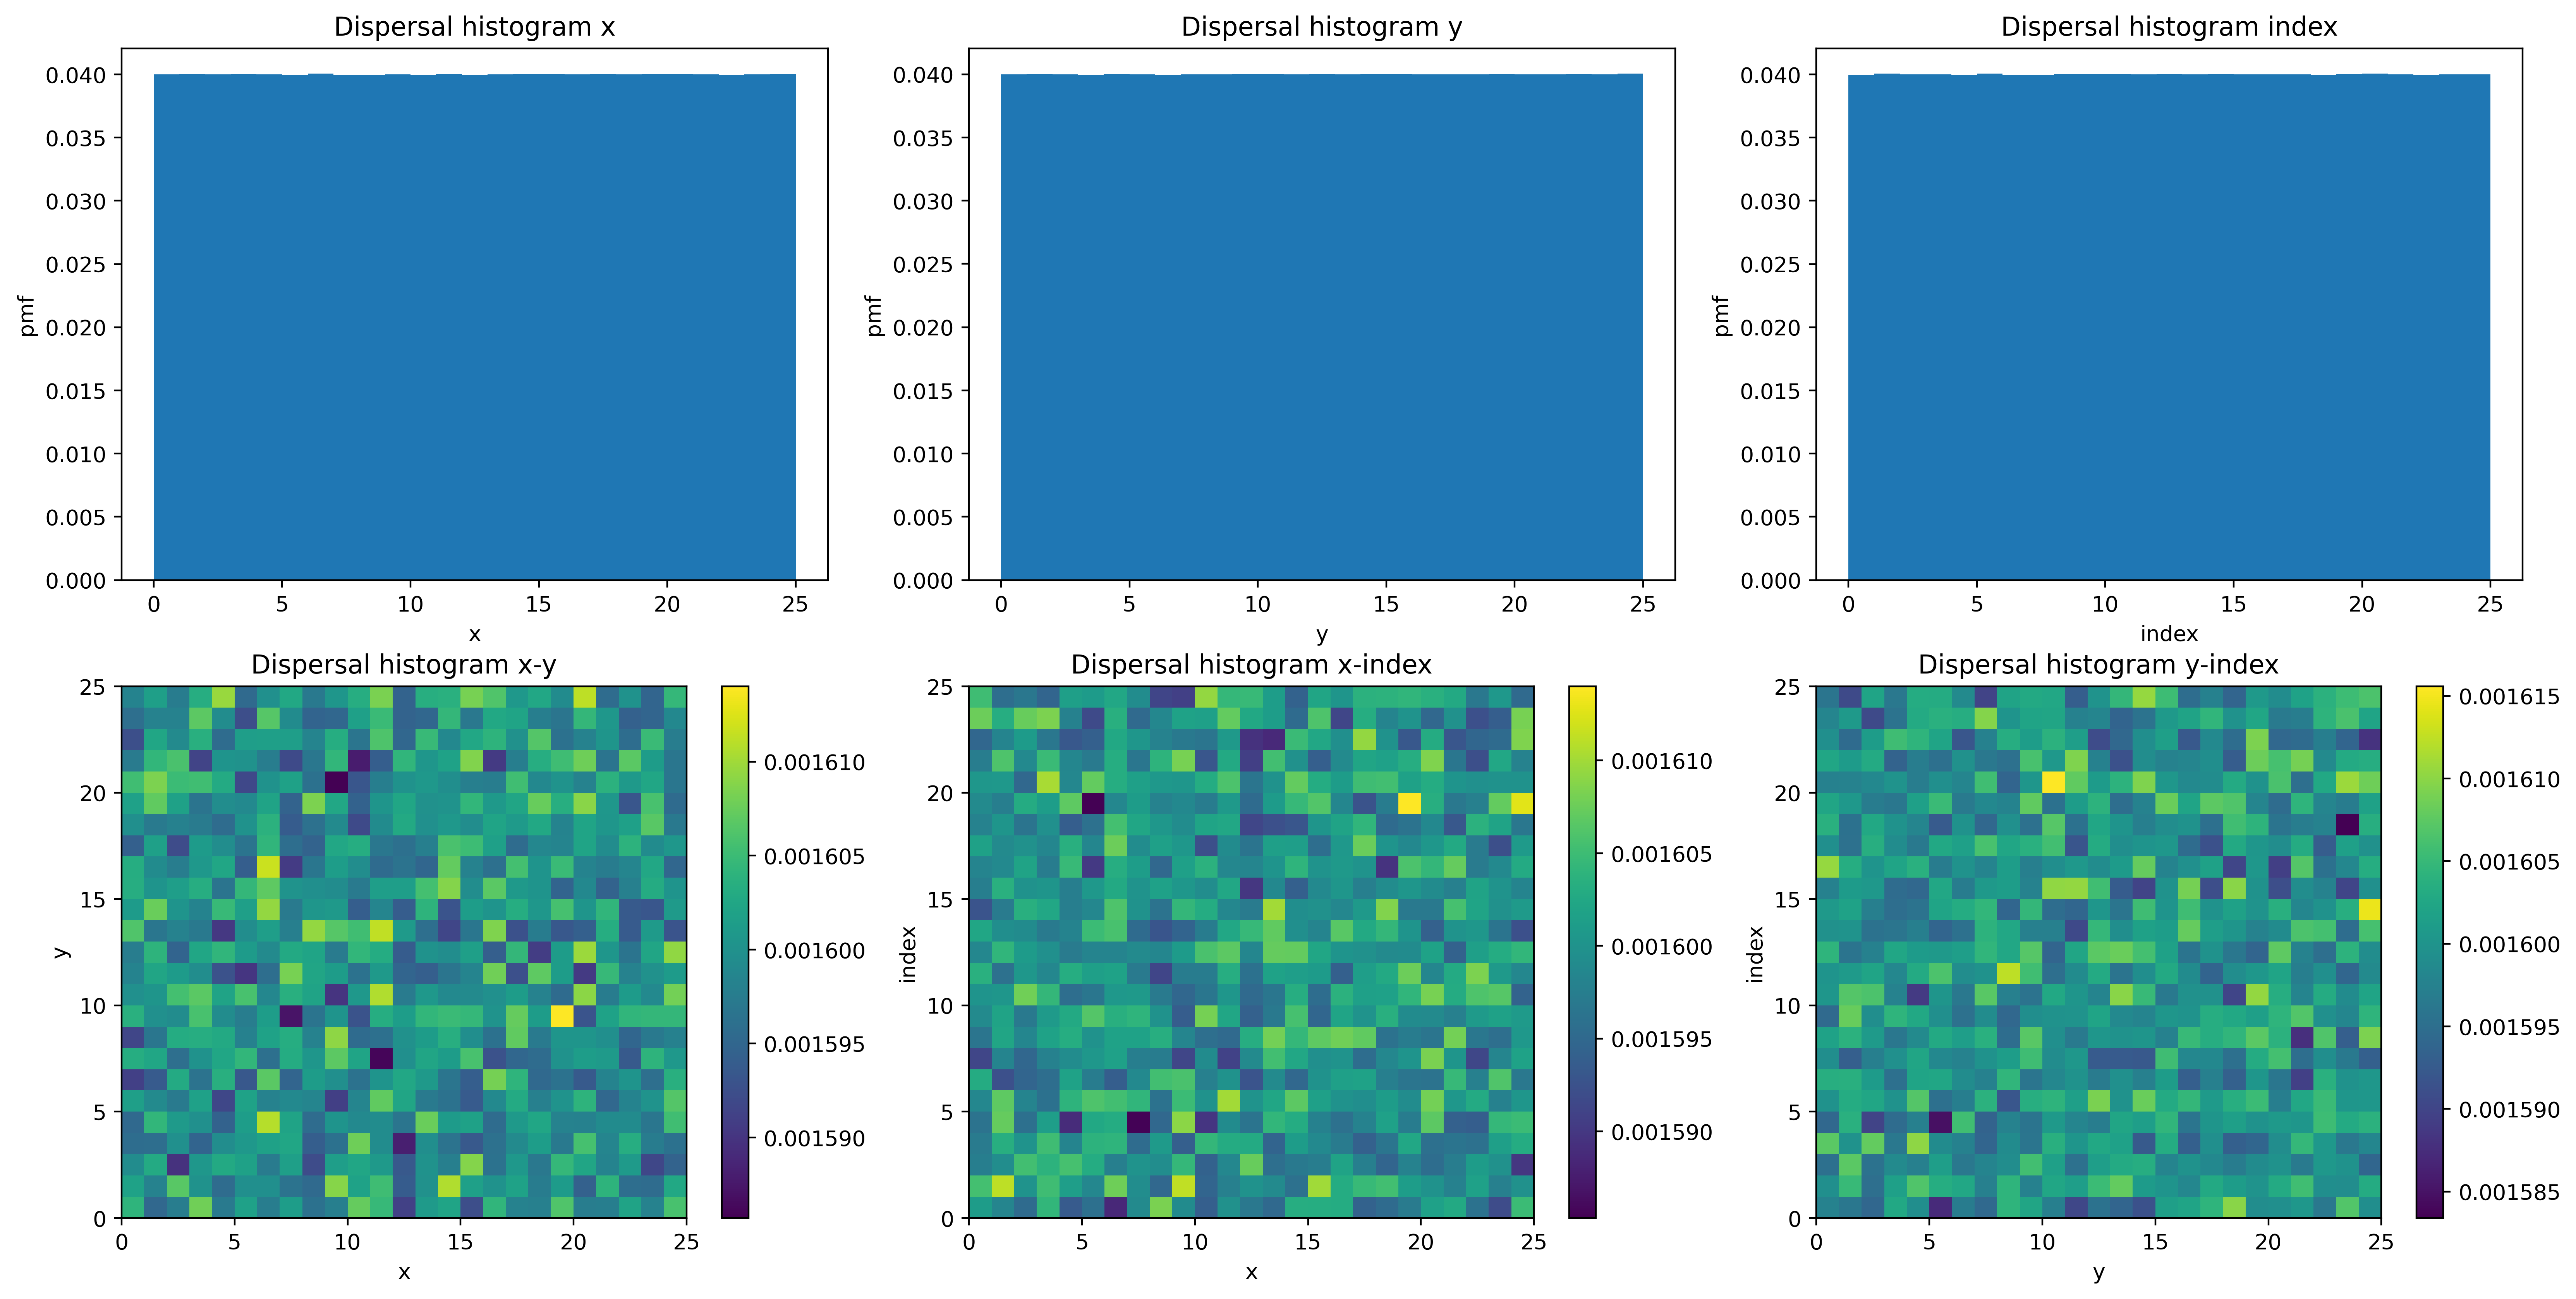

#### Parameters:
* seeds: [ 1591130525556871342 13820153437703373724 13774042670700774992
 12182218794988021064 15878652369676401502 13375248653283692288
  3091282688935021153  4839469833746298725 11342479151237917135
 12735671570715716311 14347686105606722254  2175977083676671427
 15336965969500873701  6865548845262622560  1842854445149605972
 12001984484070771780  5726731000381633920 15047805157311195611
 18342718880783004276 10984273179876703723 13002629779470184613
  2088370647663358459 12054626096242387866  5116326171929802898
   562989744043495672  1452905998324666021 15505224657555188525
  2569420827226698498 13033761678190064873 15367513261037489450
 13244175539144148334  5102577861741874749 17224751129359110837
 12013605897257267102   204208341599924176 13145278794558628308
  9223048088454898520  6932898957736629942  8487242889823573586
 11355900119389414017  1374969346680486278  2663481720554725484
  4978540412867022264 18297481377373699436 15303138987102589750
 11489326815762779787   206535722564119919 12212667076499123976
  1083766479236762301  4215323585411163505  9656979007694201940
  4753337945402555286 16938609941109825891 12118398901703321300
  5264690204210731230 13401770939565619472 15193261022538743424
 17274525370457847134  4922654035392857276  7281136165208578948
  1025879870532724836  4308030474121094265  2497029441296742639
 14115293199366603456 15849792437060379651 15699249461147088953
  2337860327897134328  9791829182020620694  9813644776961962278
  6391534538718188185 16267896117110882620  6057948858508845144
  2128304298755558982 16089944360756017946 13910344835390075271
  6532290457671554046 18061160399885539872 16523954593699168460
 13332257571116518489  4180794218905761661  6378476780866027666
  2020641877724123114  5311560721950894863 12882845067786215591
 16566901431579338456  3003434110116669582  3722034498540038640
 15077190242726470043  9119210710044397303 16307421759780509171
 15774293383862232717 13227352668636676083  5251472386663061867
  8555072528118715770 13374100505313036854  2460907243312042946
 14049853457372083095  6745583634112283195  7974156381611443727
   505630534843074468 16092396672378684603 10274841258140992999
 16101178566064555957  1500471631882567806  8399607354564989618
 16414874596258922007 10955372493417688499  3028520970806895170
 18179218374755824890 13190048249114296448 17190207107266302950
 15487060765439269697  8252781210308788147  7832618313311474489
 18301096749657557816  2438380324921191218 14888432357771482964
   608151469819978403 11287900890237488703 13808710085759999341
 11058646959677395462 12326105849750320733  9591426788722588011
  4312905435598099184 17990824624978117920 18080309831542134175
  7470789255021098407  3514430445634345141 13719543569907133622
  3323266405685402410   319517414364406181  6440238992086143204
  9336303220578404573  4157763947686574108 13931417357121912785
  9099991993177919055 17137215665742162628   240900785825913377
 12497093891824802747  1124126302728599142 14817417339240412369
  5617490736009310783  9332934389521242344  1867508148625038291
  5309531042653708234   118994778833633730   299319819559885639
  4085200765261566764 12682411757343649052 16360076326800080068
 10500373221784630394  2949631494133298692 16905113274987933597
 17229666345912234421  3544226803236785902  1963895832983920212
  6691416876149171235 17868789111772945345 13088957509215321193
   366846900418001236  1456564806795562418  3087972995075443606
   612733170558515141 15950120207563032790  6308942950998222673
  8471926455552856520   718880356116242281  3130483030183110020
 15419963228100745736  8670136159640075090  5085669074911327051
  7220526818987202023 17236340589079261350  8985340396987392110
 13380296498209903478 16040726938780311632 12909074136092459131
  7802478326186062328 11563927939152147394  5036570072156685439
 14255238910733424345   526209255207886982 15227283543317723582
  6419965429885557763 16281379474610507068  4770407574826172884
  7014246924500723968  7165112743883315652 14896996766867756451
  2392832711049947140 18111059285108128257 15914367396978305024
 15017532775502796881  3398638906121448746  6033135068173812703
  6254559176373348673 14036685131373474970   123008611187005906
 13867772916239689551 16010184188069901151 11774264675552241194
  6671868763697406050 13168397173646918317 15508800819260925000
 11274767851188562235  9847132845350408008  7653977301034977534
   954289774860561121  1283459400576854361   924568373111584030
 11297915554778830755  3974783668015833693  5646387388662759738
  5518333138293137236 15557766590009574819 13826295320897448663
  8970210602891375144 11372318814575956623 10944402605301316044
 10919583803682007447 12628533660666995821   676112826684516865
  5168878256852968837 17036406035118365681 17535472708993066838
 11719372193907638951  6431712633862897460 11105709279024268471
 10101175441836055425   391336340998806265 16133036598414963914
   199442504871384472 17557713109211679737  2297311029758596697
 11513866037569936417  5524383321686703085 12638985073119893869
  1175832851075263831 10749314758559823443 12561292724423780366
  2029393524631915082 12294310038485549551  7051375556300660745
  6931536305983516396  7935837264242351934 17369903400680374175
 17348664862987072812 12189692122220763859 13967098254343693340
  9310428739096667797  7370404033260380225 15478591098144685268
 11291946431575843619  8119480162568397987 17206886603869110714
  3323288868756168489 10317876034439851790  7611373106143039432
  2738865055594497649 17406760588103980110 16558171687574595479
  4137937676862993049  8188304964908424924  7698812945853892153
 14062083798432808461    56202331527972850 10563708224403264879
  8414442926850768016  3408393264030970339  8428554624875466199
   576321999467217307  3210876855802534653 16778618112782351065
 10765045746051963359 12305754119755659839 15177199240573513725
  6421015746296512510 15619042158763745043  5597118698529261370
 17207775708704158606 11018679874599276173 15201723494392758523
  7518024362793040714  7785999149279877267 16345810125765508788
 17582855688747963345 14550508204845838241  5041445347357713046
 12533293167787611853  9610785072171291922 10413978104739728988
 13689057798590888573 11884961539527946679  4613408712509335096
 12036831787316651691  9783448829062771693 13274531632407786355
 15771913615979441376 17312448953692735482  7866307004828444690
  2519462973663678803  7816656795091385803  3727854568577200617
  4404871402786864343  5455514612006139753  3931936896459798201
 16108340596982492599   499900428764552600  3887520977965152783
 15862866563171552897  1312119482086466659 16366978247549831100
  5129309662313930021 17738217657149660597 12045024991006988828
 11777273344180281066  8996682068180345397   159678500154466942
 14184514428695378884  2054428863904842601 10042215948105423723
 15617855322582472158 17230023782609532701  4847371183950219686
   365059722084121738  7930039456228655542  5197705589968067604
  2099008556354492829  6417567802217338748   761637349601031347
  8213692030037833683 10709488735177100987  7026666718411692755
   895143436691607364 14581074967297113785  5797259335988072823
 13443082829395707821 16163222384910319399  4503995084783503431
  2527239113365871140  8485965254961698875 11867530789049939992
 18044075378044481336 11212009854715586821  8478362425600750216
  3004800027097494088  3147671334750577891  4020649258699575885
 17736458877714424576  9240052235205691963 10713771946591842407
 12147989126706695803 13071135259027396854  9456424131704970484
 15856126473234308184  9894427954694214317 17207731904276930475
  9915166666306841011 17056502230035035465  1810039777131956960
  6777202843893384019  9091030484774802352  9384067145063678219
  4281386384949750755   875658814088035297 13081789336783642180
  6961345460411352991  9428962900297495181   976607754638667968
 17892079633165905742 14073856768056527748  4918012588216394826
 16102350160460421028 16114177911278312135  9429193667212797983
  5659137743991574300 15136215687645685429  5498387931796474809
 11268665320854117197 13613048679310475822 16970415046359614542
  8501212226009233600   399321928967546947 10408988144206138270
  9879345387232880758  8057092262522322722  5061834953121739279
  6984107100398175353 12973700788117932842 10438909128734258391
 13507971550722618118 13804435976345594545 13394839791107186147
 11606688308866123512  9538478373083640423  6172044232971004276
 15355921436453105687 11464102514447138429 14588358455644690579
  3312032827809906838 16202366406113715633 10129309412378921290
 17923033125415367577  1728852092842244793  8621584300923729819
  7126808479072615133  6731754313033677418 13769820718463759092
 14664953344702398728 17327517704277838958 18222388387909110539
  4336328500950270729 12475579698371982950  8799163662433973407
 15207679684840088063  7992407325761063539  1910527338528365719
   516509459857937517 13993980775902600277  1673345377161130597
 16827258389854060828  8375337050034318831  1919468037640787205
 11795013772393026131  1846495484544275476  2194813264834084472
 12442242850728318734 17833639389013665848  4902538981655455847
  8925278108030160620 12946322309952309193 11848615369773896870
  3789690136015916568  8297773010414349639  9720406120496268288
 16746030611129302321  5196266599722072305 10343592093529588434
  9362708335301004839  1331513100641547014 11661826754261777152
 13505186705110108037 12652048535376673404  3604054927207391947
 15190348579590324035  3515093246381174836  9706051315116052265
 16887274008303969357  5829709143470357558 15622598861416730369
 16257239395724348962  6332640225225220687  4411244834307418283
 10285275835998629934 18069445021618948185 14330077627319635772
 11459053113562425173 15421846694500926447 17397211223782660990
  9536298260958264718  7365368635741410877  9117354580145902657
 17895928448955178228  2860355351620004405  5372527378699068547
  2242324869009410965  5511001380456850778 17570655797646160019
 16153224272753245191   834084115366446453 18396373514989336371
 17461551760467118617   327682394723944874  9570545728015785102
  8134908221757193800  9547715490155961464 13757462966270479302
 12843197997282667264 14053283163180393488 11407265897249083865
  9617855588737937957  2188840042196792061 14944802684630466336
 16151234644599431350 17307482124631193809 10542845092335402566
 15341148795925982757  4715768942328020896 14765372308993157962
 10537471230459482879  3583008413070486561 13182915831643198809
 17267724057946272608  7074801769639331624 13903476379377381535
 16733502387292547184 12429132763107624954 10697970134310239107
  6866013336248618799 14596871391746209372 16958802475284836539
  4004107255905495624  5250071263833722463 16513225217120313599
 12142699257419361234  2479448700126499418 13823178631770412339
 12690774261895435600  6902323543852015304 16791093213736959624
  4684406698599691314 18398043761461711650  4441775326638768860
 15085774202433073284 13062420207249646548  8415647298502036545
 16549969354577840428  4735217617478383944  5026431008730466557
 11025191597616564075 18239359160936109363 12930899054466947775
 12221251525076345307  1334266652331594057 14643790187392106765
  5438795117977634224 14894886411591086144 12223691994950732266
 12712338469046992072  3580962818349333715  2346431267239421322
 17569617318522702799 15571498334627529892  9450438718508721252
 15678746715723699566  2221360547946799121 15430223477295790019
  7466991527477435796  3861328826993633651 16286992840708009662
 10186973799654511743  7999874790495847276   721904507954266980
 12076141124933985630  7333530418999781266 11987698547521913848
  2496934802092592943  6046893257583338831 12172969694422287664
  9837502931807237373  2427094722141391190 13371052595581921700
  7207367036571823636  7239948721565261901 12546829123214408958
 10218135290890172948  9161523876547115725  5547253839695404273
  2558990983178231162  9397924178699619675 15506050206946338001
 12113085336570088648   664081866012314078 12059451727475050526
  7534375264590180630  4877687966089611517  4799175959121878401
 11744321459274627228  6095497377126528602  4363697367197828216
  8396411225175357127 11529788574486206807  3329523843625969621
  9605964390079652578  9125095511305163745  5683934899530677316
 14280309014580196191  4632418387672509199  4274089731507708034
 12886964617968581308   800388100195856500  8576874128833785518
 11827618030661407538 10914706984826553942 12347436274438715922
   704409410955932245  5725004117994788937 18219868892749462393
  4351745039510294617 16478070751180945781  3816425058819793731
  1109055561515448617  4149580532250718655   475817918920696844
 16486456113438743138  4664174791667031596 14112589803700579018
 13877576955579764834  7481365870797718950  2730691706687899027
 10232591318326149255  8296454140539990776  8684690235090870541
 11159112276710228766  7654321360244259271   285266184205210019
   541360248871317228   275872720447763161 15596947837552128722
 16843063289992440429 15646123708826501519  8242614632719756220
  8925132267854716573  9089120451832136111 12767449412650281527
  9475754441190119834  5991760628218481707  2478102613652602979
  1878349559328570478 12837821699245387761   971287377791334072
  2305057665597265267  6270054820064156796 14485138766889476334
  8138250185717570562 10322279203447612520 11744654184828262209
 12912736700700810615 17026562918911583399 13146476634822469113
  7686250766597238290 12625016293511978638  2011154070735766433
 10106293379596268583 13070590459992781754  3528285920505889551
 10939917799329388085  8627788718863443826  9022829456891888968
 17373940387682633303 16948220454646917110 17933710173783563178
 15057500905136000082 12608840721067724135  3098063407706574592
 16685679257617158750 12939450574670099479  7641069027330996219
 14980703830410984675    32635165917205968 14170366574095679088
 10614765281835330956 10467983761469565408  2316955318063800434
 10369458025896055871 10359699437645664534 11135338968180114091
  7334430046391527030  3255635575194576513  8524752840260099849
  5686819518618760027  2474739909649501823  6899693021489570799
   280558994418012056 17646074096018899578  4456439895092455646
 10711078505663351299  9421406106471827073  7890779850189345336
  2786565979222617535  1410376611607677884  3166827031705987370
 15263718376467626578 10305044333265990363  7352482022620186238
 13673489991925565338 17167526035187863807  9216915875142073427
 16936168001891234441  4517391606529398254 15400888790444597293
 14121994257201717220  8341282419772073045 13209979344741649018
  8863388431370580701  1287532007867227197 17632387786428487312
 10888526871772392770  7402983277763374603 12887088101780999907
 13433768010016157678  7630019851935336737 12525768772040816383
  9714299605493341012  8139954973766346325 10883320607796234552
 10529795026691682044  6397778308116265785 15820497175722986740
  6786469358240607341  9469319146704206167  1002843735088141950
  6458977341800483839  2420555530916785071  2208938524261869570
  2787632996466369346 16851948040344262011 11228994011245703201
 10308931799579338576 12883190774394862931 14913826279182177960
 12811299497694084559 10956565686798112235 14405498783116799275
  6401198838326943629 15164542012107390027 15851810299976993168
 10434006258168234174  2819813887836496312  9390568589703260341
 13935006112952205024 10358181258752546046  1200742846700693151
 18155163069357693046  7758457599235254534  4806123994070386139
  1825182783988250574 16952205979719964841  3561502612192723232
  7316933282562770739   378074656371688970 10192949037943886707
 18133458217850319189  5061438997047607214  7196620166912556665
 11990738507522455086 16402218067381171739 13186405701551464502
 14137884638688940005  9346709185018840473  7213541473269269321
 14100467995271455377 13494899612025382950  8815972889234621950
 15823516415556330421  2326742766269564852  6680114374714384870
  3382017417313870508  8896907893700932508 18225492295356928385
 17178850558853575224  9355828017554108935   395360320647406630
  4140915289554065906   258320289894076199  6482479625371588702
 10909279331526461668    76618656124223147 15842082335247778085
 10671757141533190491  6029376315032521800 10815604285500280670
 13069878505516262149  9853225787513198767 16189640257244785184
  4225636479823142014 16040530595350986297  7661069767368595681
  4700761724630163843 15989610405374570997  8442150244537380523
  9483937890552195748   788774387616885227 18226329531115310225
  7311562959345792406   345492426518190532  7868676712978449901
 10843642859175984653 17108136551716531940 12490220744303957988
  7002985025290004746 13930155077132194636 14663793631714603406
  4960330473270132603  3476633379958233525 16575442874622851275
 10893688318132851635 13412634444106845362 13176411186680091939
 12098308032614361299 14107017368339309678 12777197807409214341
 14921863374255124287  4817217103971818287   352441433109433026
 15733052241053563795  8434942152378742500  4244801931591067866
  2866108805227138551 11770339340191954041 11235100300770982539
  1387338738936008710  5712436848165730500  3649267298121429257
  2079304632082380422 12355320940659938436 14675156555039516870
  1410634797512268938 10977719362716116305   562995294669339510
 11167076303621149568 11575884272821895175 17667124133773669797
  1602531423609058446   701794739090489101 14601474214179047176
  5968935689276839338  4907840775689358821  1274543450731214464
  1283121189162015451  5940442814008114796  4068518765688001224
 11358546822330188249 17666789629312195909  6597692649230381538
  4250224655430971275  6107458319033169596 12716897773734016194
  3069343425011745716 12302928694049039850  5018293814482973741
  8842098390868292634 16078592220275423228  5580132863789548723
 13425693244923472247  2140035315114509259 12663644580243931559
   578925717392816105 17868505489011972721 18062507769590128500
    32078028866240474 17721480766906354488  3606276425308355045
  6720906794802685203 14107473910581410934  4483647737060753257
  9572898857107459805 15791579891880606211  7614834725492775502
   354654132117508038 15586777897764537010 14864842531861619893
 17133768661445883172 18385928126892861564 17224700130232163351
 13144509757950231492 13886217636187490800  6034077241097507944
  9396883810911297886 17058535494482750955  1957977583731232501
  5963649673295229688 12447730454723643452 11010476357256675807
  2658270999127336980 17987822121855794766 14025548929932613451
  7273771062338041683  1217353368517701550  9814549898890505299
 16156838412544842770   470095493837788231 13346037064558794977
  7271955848901424745 14839280583471153750  4922858893999196989
 14527006966532192361 13967090193842880387 10491980384638367478
  1227452181654265466  8303708549345391878  8449348519769769632
 12900721257783563692 13536598226469938800  8241479630123354584
 12525078261056304772 14538688375932392241  3519801181032093238
  7622901460384083121  6658155409337171426  1803320732233011084
  6211099019944942852  6015512708484546223 11112215014848158853
 13679418638852026809   145034666520908662 18409493686911379157
 13597489609286505370 16647949578935093629  6541517208520277498
 17635719670613780413 15623918990149498170   745010039466078801
  2589134595146496734   857516799628781041  5894154978658253447
  2832949505409411717  3984413113132872873  7253393994269681899
 17022255331610907495 16217813998542666901  6589211904753528217
 10825123991104306921 10627076099119662716  3105553834569509785
 12591399612477120227 10399933054761277161  1779760735195115640
  7666587857487323037  7964108272885004787   528829428665159675
 17138119926119438908  4512682267770687949 11967112240455201493
  6788443408889467088  2230452309660803986 13053277750783129391
  4340161749453305007 12175249072300192260 14075861622946366321
  3474249996475004351  9225140322325743427  3504342945969928863
 17209454816130410754  3451314987470716550 10282015888843632882
  8122614426926419455 17216826872951618485 11016013706636831907
 17275654610503675961 11202234409451073199  6573017904754311744
    25925592459005902 18110793007339037966  8639174770249073830
 10652572034325295022 10869873286748915818 11211753920917192645
  6811996725449876001 17210359556106114608  4757183371700448197
  1126653164857566921 13523628042849371449 18384824033871781588
 14533011832956609441  7575266520908323672  9290813841934347190
 17406694260434362707  6565412996759032917 13901593286326967414
  4167408450446451980  5165517010694373858  9699923479499737776
 14809010030193600587 16789063347690810674  1703451614601762909
 11189675923740591228 13875314279331941163  8683391547489720202
 15626210540544720793  2860059851039683273  6522375037159598240
  3504655675077676963  2336348174104064478 16951262016555151147
 14974345600277019512  9337669189277424363 16599731743202762444
 10036156100837083611  5259741363579031672 18381158408202556910
  5883986708311023939 10459940916689238425  9057912242505471528
 17520235015017954913  5793441978072154422   826039668692514481
  9095027132607939248 10451886472725951564  6416946997137588257
  7199664318939903085  1570066184728418630  5884293014636638497
  8567143616256689450  1781678826080230214 15811447120019201871
  3717350454843916723   342703061340576580 15999075425503138507
 13518258676461679487]

#### Configuration:
```rust
(speciation:0.0001,seed:13518258676461679487,sample:0.01,algorithm:Classical(),scenario:NonSpatial(area:(25,25),deme:25),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:03<00:00,  1.84it/s]


## <span style='color:green'>Gillespie</span>

#### Fisher’s combined Chi-squared test:

* p-value: 0.34244353055256915
* statistic: 2025.1035412017445

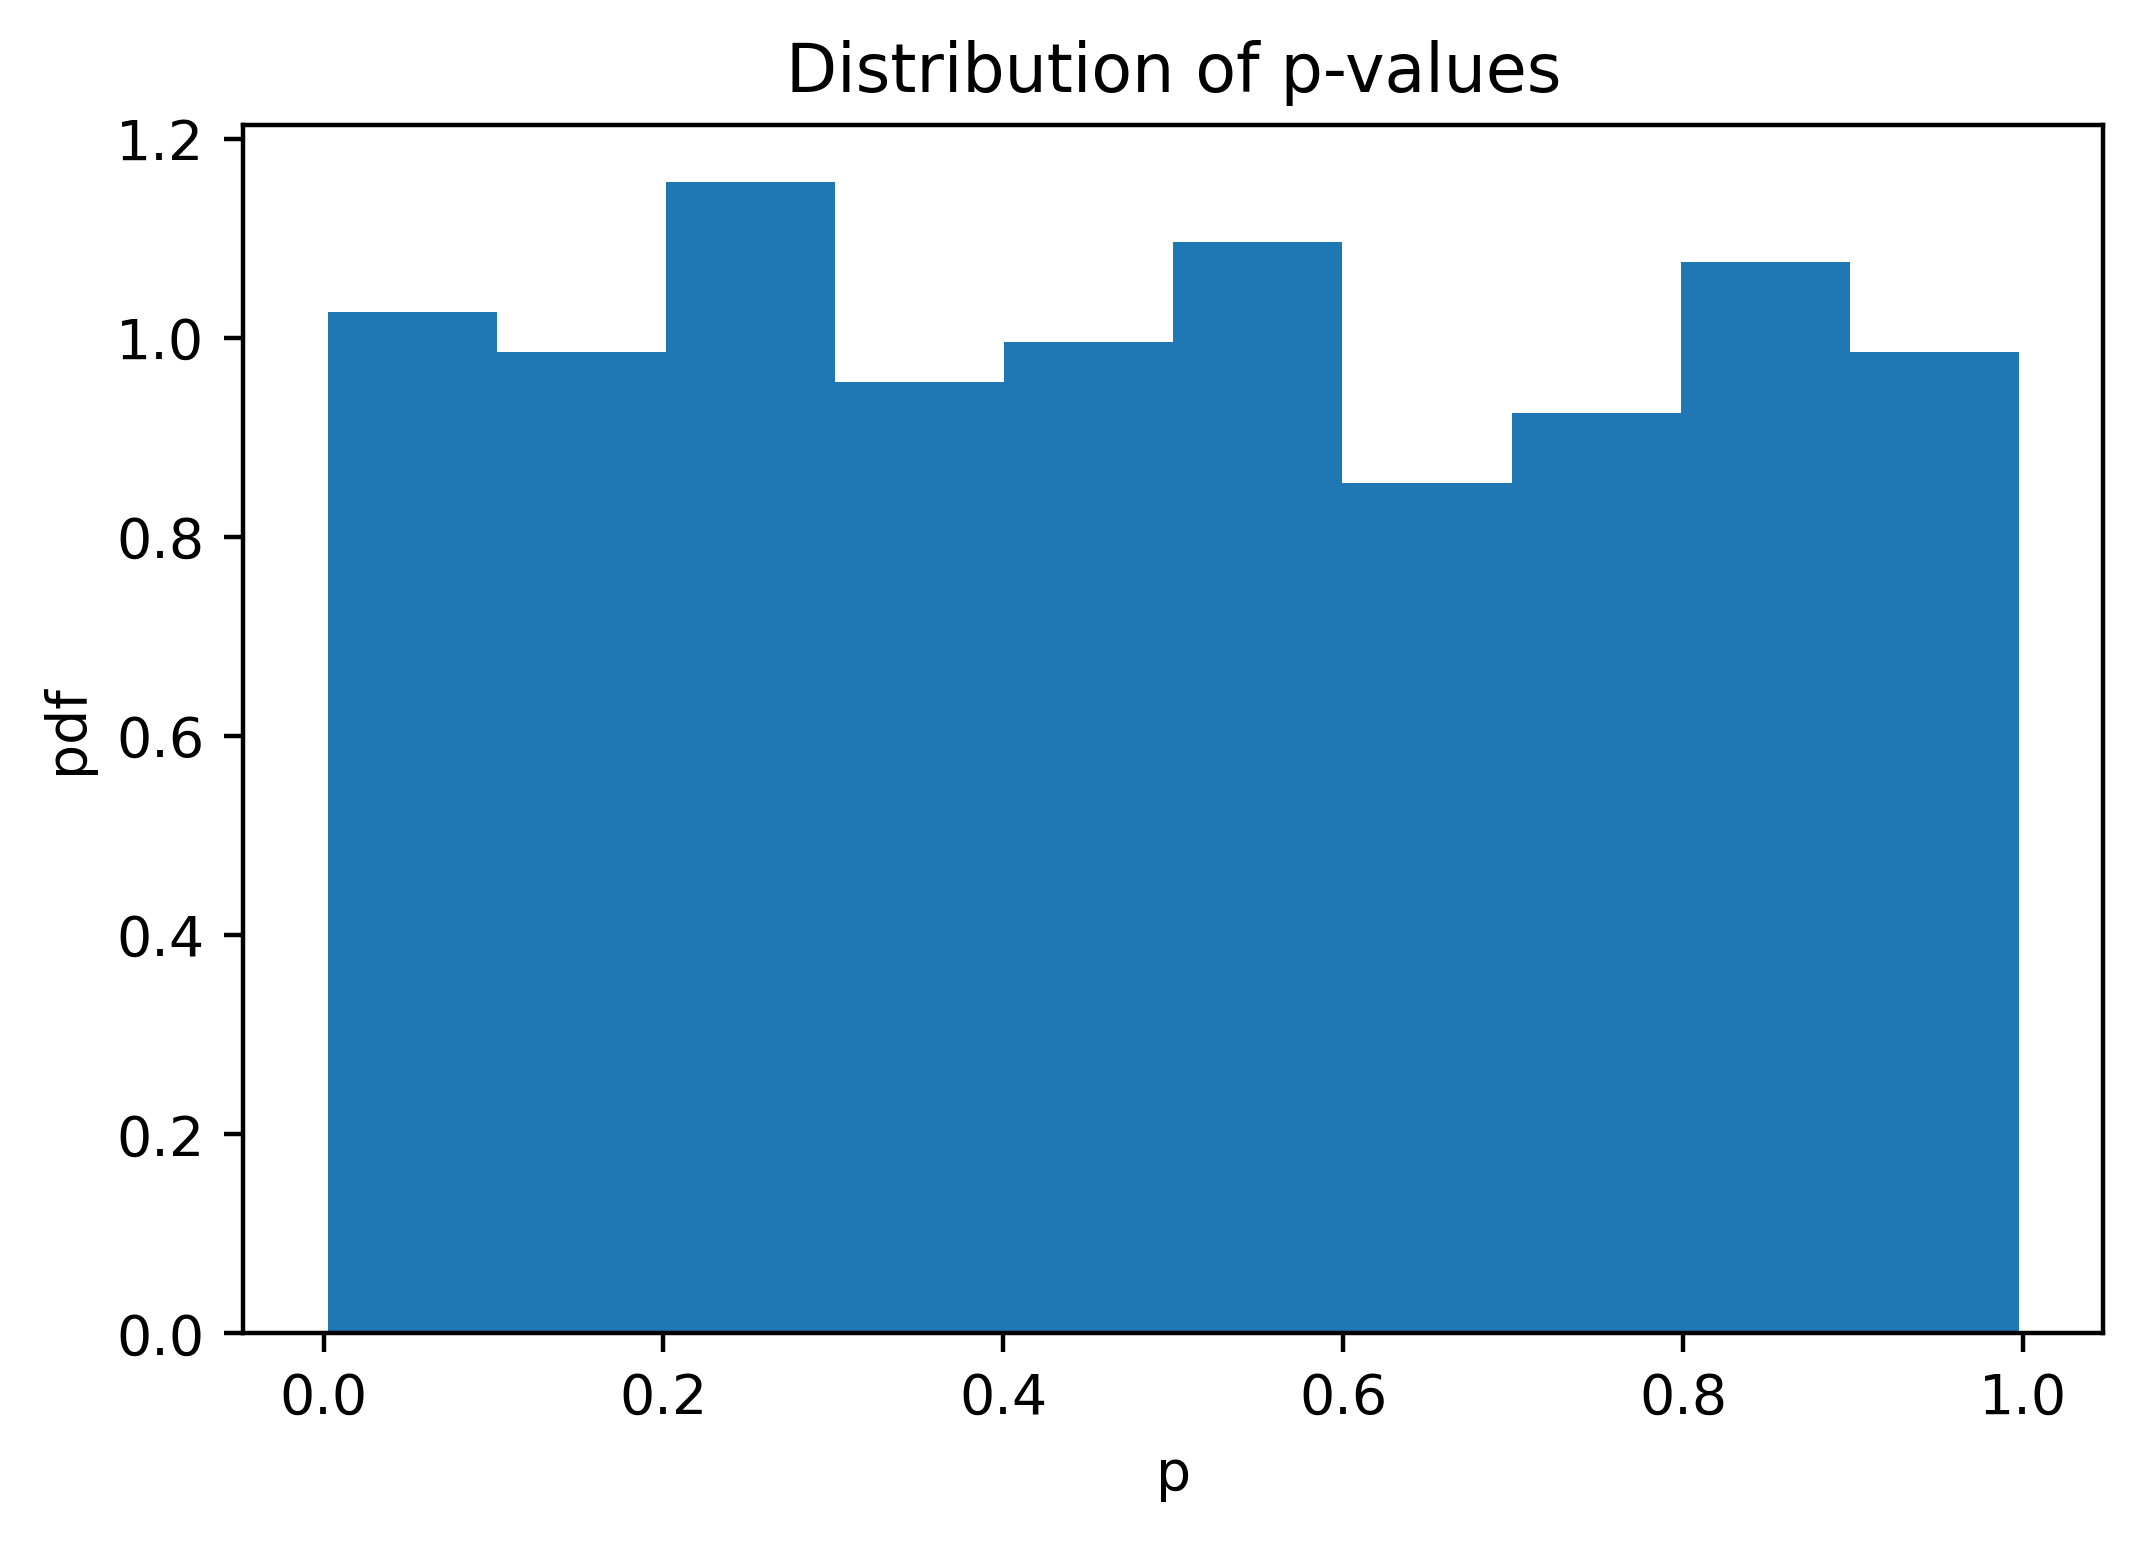

#### Dispersal Histograms:

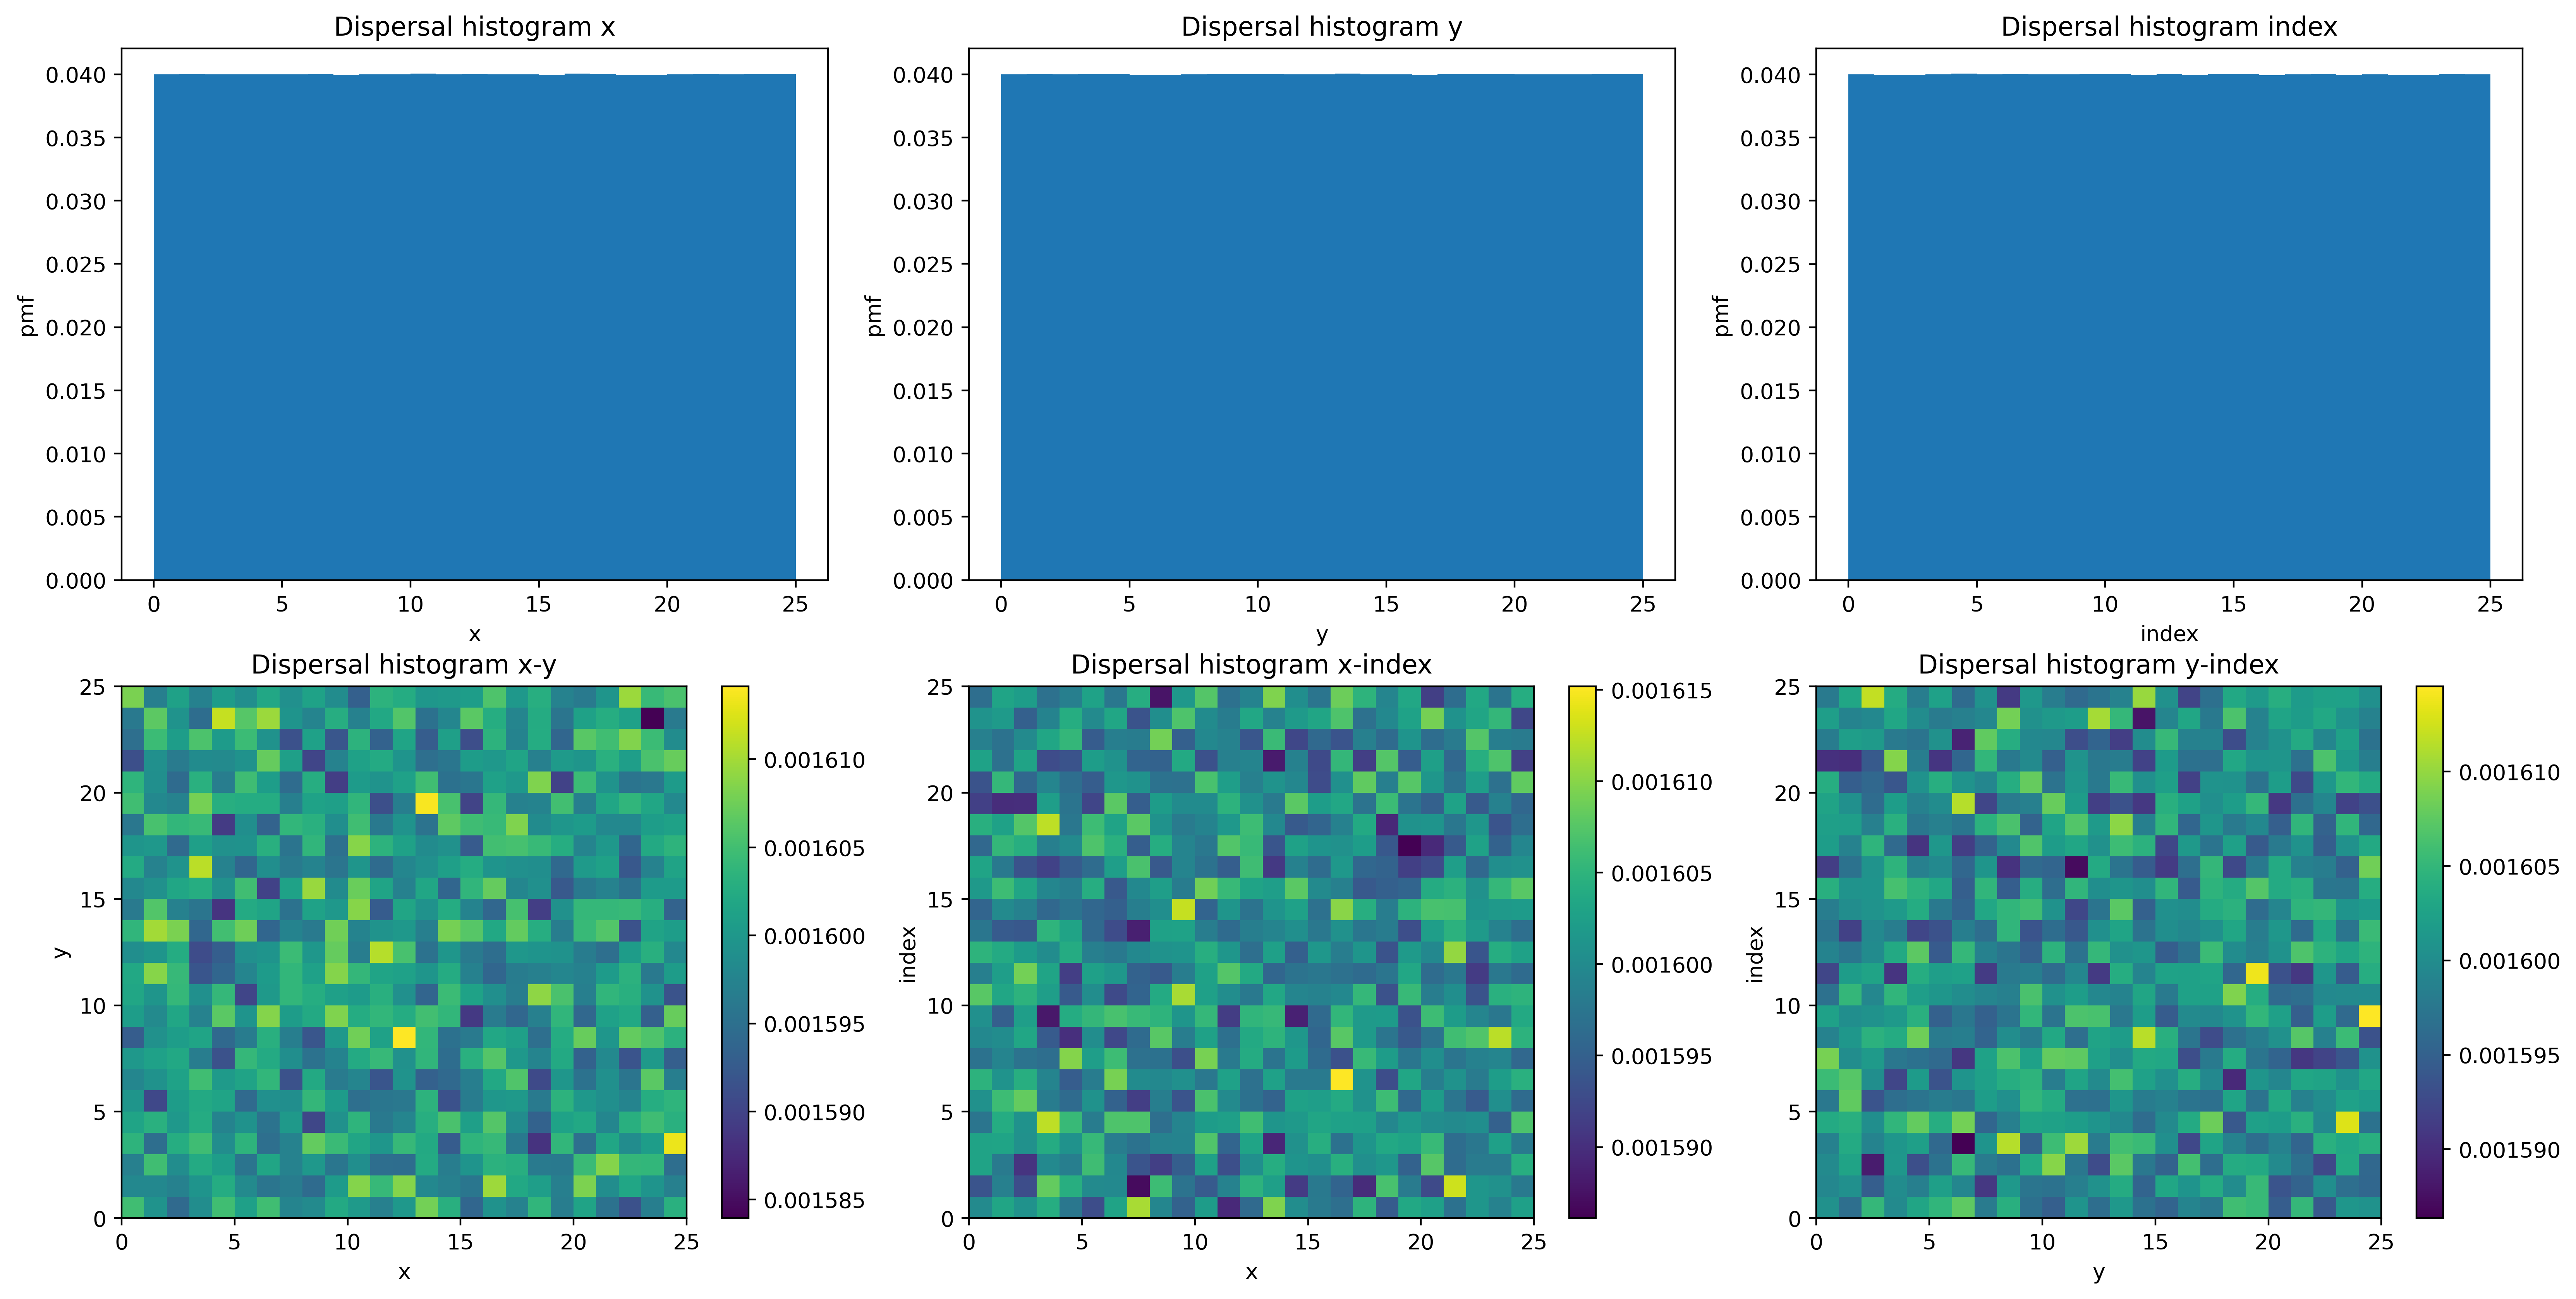

#### Parameters:
* seeds: [ 2381986916302582642 15380713783402052937  1994226649685636140
  4450877269919611172  1507001056819793667  7532838580998990825
   371919852950820287 16280423960322344738 16055875719501863488
   401495871791843461  5644145383412210667  7353776664173403820
 12624818268324661798 11358745063476147001 12718223016060743853
  6348726179527594850  1295695122611413113 14162412479510207988
  6337105133706758279  2115414055922989064  8204454390042841510
 16666050710775894901  1500275384177468918  5542224385008348456
  4719253523662468650  9900211903561702201 17882655660634760646
 11166893562239779263  4054763858015454449 16382864045536118266
 10286753791590612288 18253747278294764744  9993443130033880258
   807036225217997382 11907885473029898166  6612200031571846560
 12292782859340950864 12946242378494345447 10787876541054162179
 18434221218637585159  1838976493972666703 13116454100517455908
  5585660103536030180 16708501302563655364  6646929197919209545
 17338213492203284442 10045332693655572966  2458513604162437863
  1721691374824492692 18410175443182644063  2861340901553581106
 17417418994296977679  6283567562958372321  5325153133196225180
  4412578549042735085  4905563181729049338   160259885658768797
 12508347001549466170 14389186963279361848  1616828030326259044
 14768091519696086233 15715007967931855048   290263543931921216
  2297097942430448260 13838637195297736918 17957038045690766286
 14452160094776273304  1303737904261278912  3998246851188752986
   637506995943115463 12738487293474401159 12926134280029005710
   943918644861289817 18120869019066992480 11082637236229457739
 13654358846637576279  7315258965284841872 17656692735207084225
 16909608063810480219 15604683506476048202  1057361875733560501
  7763229970881952302  3576819367483217467  1908445127047198493
 15904789764216188985 12889079501237588395  3352013022330095448
 16107828572887094409  4112033759517032975  2953762748318418490
  9407027805130931495  6085051105465145037 17186464291745476215
  3191274174891170828  4392430910176112503  9159737762155345997
  3340528515671145408  7890033094197352516  8162790301463382080
  1538971757144193428 14857306728169858861  7102199919925333591
  4638199931045861183 16467134459078841973  7498317457997732666
  5728798154443192444  9679530173675119094  6324391330936868399
  5045758205276010492  6654499277859640142  4157312184519246341
  5824510680368170126 17838684961225659459  7485050157650618737
     2137953530788478 15940563398369360702 17700629697615635245
  8574685694791910465 13187517577903478907  8753866797076953488
  9235120889235394857  9737408288923422935  5836853194130405021
 11562374379160263349  2391562861161258798 14403522642099298306
  8098598273251516569 12892135090367608852 13065008993462310511
 10326287592714280448 16114203211327530072 11959951953432360149
 18062359502159959728  8719849025156660483  7212737046579970369
  4914386867500225794  5634158521867701182   961613196588565526
  9453757674019976548 11559357269086585446 17662140115066198009
 16852400215260061713 16573777111304478183  7652755719163867351
  2521335873468643541 13926036134353893577 17025101301646087634
 13584052725918308192  8524723038238957327  9010469084721398188
   950904496247700386  4718986490624530153  7539420952883718417
  7465549682223615256 15845356068473191135  8522181485682403231
  4098994722028141717 11861555514499871047  6218448402495304167
 14358279216042477140  1537754561988736841  9326514943244456054
  2846250664519642752  9118680594290972515  5819159134912349603
 16391075469466711695 14441753766911530524  8112354147947629205
 12768357788504081232  7519079267697783306  2677865228388357350
  8435607421846309603 16590671406770737426 16369099178922140892
  4931855919681386901  8724850888029184837 14319332460526699211
    86814230414287688  4871459198429215153 17020535942162673111
  3842993858691382582 12363190590670689124  1402461951709880279
 17738185177357955577 14860717038179494802  6273374344611190749
 16542503111385490481 17473381446871030815   516157190313653146
 15882155282439235407  5491187062959179204 14325056824692083912
  5450207236449553693  9196087172805784563  5352566266593185780
  2058617317039754185  5100639536318355419  1888225588979167404
 13755983646383096260  2811832068332942129 16896568463290932592
 17278797930040348967 16197443118540571318  5747943328624014820
  2233759227351851834  6155695505370942721  5337438597446362241
  6828581683206190604  7635212780141625776 15569491054411669449
  7409627292124728730  4943112108408202089  9500528847964776890
 15577233805549406824 14470175122911463943 14854777989276395025
  8373899650243286887  1812466581223605166 10093002859573678703
  9305632723831887308 13573777207914559704 10263416408606955761
  2103807241087890490  8174641590100145338  5887590737266932639
  1640804876803368760 16225136519053522900  8616580005245135137
  2512372555388601095  3256027585829042440 13996777222095977258
 17993106406563199167  4757324331882548981  1907019222055579337
 12879621619867445643  4907548398961757417 12642961467541701440
  6822137994169715929 13052802175760447766 11498768377684713580
  3883096901167306561  5661739157172655577 17168944841939059420
   857195941500517037 14298784337783650775  5560620254358873594
  1407939197583293316  3295009491218633525 16938380225582066548
 18235764997607462335 10231566811844211569 11464461912554519863
 14652450376656686236  2015162889982584315 15784228641929677372
  3180025872570342300  3173757813918117428 12470589602989476953
  1456738293307271432  5084744292430822619 11370276391014621489
 16035342408888485855 13571278341964708321 17859848058523593865
  3472331564037983164 16043614178365069154  4751384711762247480
 14859794620230043583 10251959899832815709 18013167611634923726
  2125731471131078287  2579333008950742214  7893534869731716351
  5823882889836280365  8095776695802525911  3956484463402843621
  6539899484133434270 13859479760349702355  1448791982638057225
  2278912117491343191  3312163908404915052 10154226081292676488
  1560502857962400574 11663723377937254622  3490495420373231858
  4307470587805129092 11607946204979770199 12994153762151833367
 13905491159998626277  9994547522203194378 15907259052703000803
 10474321230449475743 15782192981342559169  1746667479104469310
 13871790653916438733 12204803741276261563  6255018877071815253
  2708521123828171850 15527558700046599507  8093992218662260557
  7016225603302677236  2408673909643800847  8105723445411954650
  5358226343121404386 18371063481094290187  8715624153409952104
  4885426976646988349  3553215151797325270 12425912589607767697
 14576372999413331923 13856978164956055789  6559000146902674604
 17735302228943388031  6333732693200926652 10665164153058421973
  4845280582954636271 16977013549798595365 17117368850031795835
   615340086601200908 15327459013348861196 12903948956128943620
 17976199832250672867  3274538250049983308 13607619561195346717
 15977805335960283316 13499188933418372770  2640064690243384117
  8355185889227742285   490020667761402391 15296142454634189677
 18175626904745786507  6004918143079805277  3541532217717729291
  7268037764646038926  7103228158040002797 14578195967485815009
  5349545766953117022 18111767850436843604  6106205348461097629
 12898342007612689662  7762777430618546177  2156628352108407708
 18398217777729449212  1652744140399310950  8974991973413896626
  6689663487398600939 15882789886165750515 14836012767149764061
 12007661939881003447  7380905326382563369  5071462922047021260
 12844556077885046302 10473882890919364317  3497769434979818600
  5464510919078516699 18248246726125004391 10644107304772185387
 15912979361445026698  4052631041180224629   388860545508786937
 15886578125176514054  9698733713052445175 10097374916568470770
 12468667110205877296  9422741329674918720  2324745556156217887
   410551913110201577 13334696390658224874  2895031727692584146
  6145650977954933659  8645311959660220114  2898996911033003811
  1094369533388005513  6173337772923567085   901620745756028143
 11792218831936410494  1246515814408459299  1053488907325193281
 14220336376330865439 10061666786199387707 11450482528997824597
  2797213709087833957  6753544664217299666  2035962768263718032
 14121049618654209572  4453887045933748476 10075375321444286187
  8741606352919435852  8087366680463909588 17952929852518888643
 10566665905798402638  2195792353641130082  1530528691423667996
   253020658662988411  1536690818425169295 13979039320266162240
  5273582389954334276  9973147352706338100 11834468338127284249
  3240151519057473271  8324988392503450072  1909157228007021745
  9983017705598683608 14769989952634094864 17390016499169224007
  2402313319127755921   480480097615755085  2460317103104538712
  3789908859025395536  9928715434861297889   948439756632370365
  7321065198366017192  6885297977983033804 13628184362400569005
  6472304396420827921 15252890280525363063 10028776067263601813
 15905487811350786515  3490130288898334306 11300237725538180391
 13987292017143279287   761723316771683049 12105937925308246388
 10066089303370941850 11610568020312783295  2111288992330894102
  6247853522319713436  1461708852678606516 11612374622137195144
 14951410119729401697 15257988407421204905  6914650830415434456
 16710273295171182475  8587840203868139078  2525677419027932951
 14381713277357362554 13823840561886071449  7014373412920063736
 10081207912193787996 13850897118590607013 13031002402107210947
  3920904294504074242 13942074314512164211 10964452685360850247
  9666639045270921189  2679309542363023213  1286363740172468797
  8191531627765248758 13052722408895379443 12463873229396215168
  4803003429916619622  2149195611514376385  7885520797864956851
  9025100132814445132 17158252344672511612 17955269188558314616
 13794009477383266656 10947448717659215937  6581595991164039923
 16053094217984866778 12614965354236941227 15504118940520040679
  8725917795076333972 16631559140950121374   272490234203036539
  4595624277047443658 16048797564892134137 15465747849009631321
 16300959697092646610  5057574773245127807  4626392826870210320
  1170727714436192738 12750203291395301304  3766645982497062072
  4813177646694607566  2600509906725295377  5896616138837009568
 12172906893735872553 15014603127669987655 10204876203857866771
 18094888126363070412  6925751154744323887 14445596375785126924
 17934673201879751674  7653238997812364475 16915425915798995140
  4986238916960641473  1723159523896839928 14759937282101597229
  7306690607015658994 15052589751466395041 13647789969107202396
 12741258565963310202 13366628490053333048 13253065623523745921
  5900073380373624057  2545683453994425735  7203359038400416032
  7180385707990910583  8364278714713092105 17080013884058593081
  8393513001783834844 17764240732187014282  1052091999776799702
 13338708830270985546  9016078210186447997  3621566355457781793
 18295859918511647288  5213953355920119187  6119754809231230299
 17324829434141068671  5109155731539867283 13112909007432045819
 13851252133513519906  8755824740339975591  9172367106516931526
 14198847894707152076  8042380971630808074  4057499420320347388
 10782643538811635055  7604329515618683268  9054550253791936223
  9633831034564572681  6515859751156051959  3592494835282844155
  5341672709699129786   899068539272272910  1526733952475781741
 11455609145245007169  6209948932219272740 13948375037340558996
 15274278321034683909 15800002402202447405  8863470276021509696
  4311554898924363645  8163965049419038534  3002177563082071484
  3719508068054415681 16495066623565964642  6224292382690096075
  7306262773872445053 13719053886483394872 10422345049585939542
 10683481315557852558  1853751069378809436 15914683409693428610
 12088764299690263828  1583906218255854913   763483526555244956
  5296600140553188975 11636935367690591101 16542714487219484799
 18372912173187133677  8544852888904265913 16790164133670370534
  2619154641360138090 15364328960005405068  5779395005072705497
 10933184576425304913 17479725077152777431  3633028747642991373
 10181859595930144211 13799082723608343848 13643594038587955514
  1189591280636415093  8481219756872007648 10252237711081597165
  9143950975842773958   239621968699975522 13235225698414198202
  5126773917993747133 10081921495450299126  4015639209999393275
  2321773782353194056  9000532297498176980 16445235940350483088
  9643482606674334233  9568990083598743604 16998601454351157295
  2264305007127764497  9565572422939947275 10533889158463264103
 16547026454143480279 12597165256995819493  1261934881681500152
  7488723842923741877 17816629508391302289 15147040519862899069
   323165480621117964  8256100289190308232  6541404835554758579
  1137960813833672490 12998817530302106749  2589004156706806072
  7705018230128236197 14803784752484647881 12592714091745255924
  6886694042112265863  3639467313624087326 15344849601054682269
  9214577907231352697  2984973270113703557  9486941867676652970
 16255061362719616911 12082898786596630809 10858821917427066204
 12034460006148023517 14107477002115365011 10152887315444671319
 13971894593335604598  3525260842054042589 11008593742422456426
  3572151338352815109  1204517001402721476 17745093085579614526
  6578789278568458257 14742799849092791721 11764786129969965407
  8333814300662061213  2721431262965956357 10839369780835463467
  7006021222040513565  8224715284937902637 14860704063394934848
  2526904778695233834 14078071730017089175 14559013429575099195
 16565466430775721054  6462170596536293160  3127169774378267834
 16855984881105236051  1392569421245365250 11807102664313240472
  4168748166137929047 11840195504187635688   863750860734957214
 12605061335088845317  8208664847520044969 14112463236625414954
  7457374647145494091  5985520380383473617 13564197650342367538
  7590399082586400400 10730417158600687061  6337462152070536211
  8242220426399572867 17612005806088057218  7375318047270485740
  8038942224651848551 10701713170621515222  5080876774352799873
  2872099797278757150 12471110220727549655    80767580653275005
  5841760980234298548 15557904856831129182 15441298006768859458
 10076548774045398011 14998589961637742076  3093371587385250525
 10047352041169778825 16859836785841895045 11730314383051224032
   225611715051273022 15432495349453672761 17933946312600458048
 12081256633172628178  7822377812688134454 17955591959342525738
 17336877165677774016  3488234012086772665 16611594022140183528
  4119420656686181210  6374898887732676304 11922861562686036405
  4265265190033969860  6518781037024050332  8738674865471852744
 14339681245562067762  6525011883388774363  5632234728387971244
  6188881908884016202 13289765750696657787  9320645116370608280
 11656038368068436957 15823734225317383104  3998987046153664336
  9287866494624694006  1839948060839391042 13163204961878323481
 10259147099250562373 17080006435525958451 16336310206190141829
 14023515255568404664  4360069379667224904   511514264815494637
  4519815599509220831  4444274798904813900  3161116563800043421
  1735827058998578982  2761698415928487224  2798480350135311218
 16471725285981170876 11144278732340815301 15089094427398526140
  3259103002699751839 16129724011652528869 15288713643967436319
  9368142486060752179 14254652535884404641  2608726486677552120
  4226464279804447080 14754569194495698391  6786759826552460945
 11908866732432506384 14963534938842144398  8409887506762210781
  2826003539884576547 14141314835064639928  8466914249720766494
  3718353982352144452   796411175081744291 17131091392531422524
 15802244354485121287 17200178934539012625  7187920804318952611
 10504177685153504820  3704438407961492094  4861107488622570388
  2361181827914059907 10319511258924437234  5761153023469730945
  7106748150143127558  1574299166116646887  6943823993988808837
  9797282544509683824 15575643537530868480  9096251660127371546
  4601979620218585830 18329422358887411968 12581815476254293544
  5145429380367248592 12607084485974057505 17529995837290589639
  7110228709691994129 12181729422154128257  9011548793571312995
  3376128745427512545  8894195007809331346  3376112127755977117
  5637989097462984868  4337187852972578073  6602877438662001039
  7824063334957719352  2324091353726916003 13312748144793125945
  9927148485414638868 16252477795686111306  4761806417459927186
  5215218441147855245   194944920776509900 13275719837893718122
 15299018189199129888 11463456410241185499  5365303176298565534
  3056796961333598162  9973031583952389907  5236328461416435442
  9661016008491653098 15910870003014302355  7138479880535375392
 16435746888174361813  2365586329673564655 18329430316094586822
  4262491696946612482  7647360860449631393  3633886040767326244
 10941893340864454061 13091929880348285505  2692869564787746462
 14932448162104689968 14618950728551915772  4779856911492744824
 12403495836152342853  7255597010474019150 11463725105442890864
  2148448235346836449  3578458766177487437  7433301286786825086
 17072003238251695267 14717889749128700095 18224931653059532060
  7843249790740366734 18248230341196286054  7682868447254876065
 17146119594062864354 13930204948320328271 11622116881364207863
  9129982023520445872 13629300797032417958 10536231553471683333
 11252481446914043218  9460778947274872589  9335223154973105013
 13540577941066160245 14139994535388681733  2250336653462378646
  8250300346746945804  2867866633867637690  2107781056812058496
 15989024387894425908 13988464869790135549 16323017952158423274
  9222942601619025315 12102549972601960888  7491389111341137795
   746904249292321867 11188444563573336758  8972291292651882864
 12453672071323890782 13862184893399120877 11910760878511463848
  3897306375484384250  1405931584548424914  4634279591241418484
  5897636777101062152 12843622949948871781 10306562750922064395
 13930828676076947854 11550670505557128141 12984000133879939256
  6084801717254177374  8011135871998190770  3761233464324504469
  3431671264258642630 15672717178455717892 12812711088482741943
  5027825791343328155  6988158040256022068  8117749599674323134
   104301365562241389 11174781530694083352   203584083253551128
  3012678867952081390   674392830655560904  4536456430191181983
  9472708864816070246  7814224877838042859  3537365820439578900
 17751827283035109595 15792877439456413134  3158285932948030388
 12337254879298415740  3199682605873899835  2428893910604888622
 17626827336683071594 10152252112133597104 10829271255355256957
 16563961069873189062  1216049551487637320  2042551541423364007
  7535303009454502930 11140763422061342317 16278915399088387798
  4749460679982458164  1425786141140506546    44374192722529657
 13957340753897229911 12910237215864472808 16039633100530403553
  9237246701262532671  8244041617696231378 11717805532634195047
 17711686975924808737 13532964037791877542 10917431051742425848
  2813746204261192031  3903156888847328436 11240760101049093123
  5395504138674909851  6218944591368184103  7051808691048481177
 11482596830292530121 15968573496583677748 17466849605814586615
 10626958203876414229  5456742066299217165  5447446727091593478
 15269309206508406968 11980192324648647599  6499165768202156014
  5681304508400347481  9305096297152841566  6689048867762839993
  2804131425441425515  8994461577048250905  7084559405728463864
  9828024754146707263 13130589857375224381  8737579912470594759
  9668562565343103614 16209949343049706519  8479575465350822472
  9444113787399824544 18396486915667093845  7871435388499942036
 17604404601086786560 15422902405481055432  2882819054881364039
  8853290255173807745  5099367527671340619  1762713449344630980
 17058167261546154236  2440221965748879927  7628064944342161504
  4550372859136411099  9350344801426817239  4589252250225507566
 17181872366514991855  4192315239809950545 11147795075328770663
  1293651665323274624 12543316951465850098  7455764691108023287
 15939025910034540932 10018184225529514341  2909082962600702195
 17451228491575852787 16057388748685329108 10206835748011769753
  5628086630619454473 12459027254587638622 14990838190553496411
 15168587811394577928 12248302930043760538  3636294504472873770
 16481136987361049999  3592133361034996660 11413505695787157255
 13107187329382020957 18417856567121961378 15714826742605157821
 10326596512824382778  8660610997975169346 13963502155208029129
 13730850665922510565 18288291259680367856 14055998668030984966
 13880425388416987980  7504050330733914519 17654858892982493846
 13080693815921611712 10191657377962192612 12244483837674153039
 14180458964860731367 13266459736537386156  6147699813848410341
  8666556091607813135 15615901856130849338  2558653749347620619
 16957546017839346053  9829033151159201980 11900896120559973389
 16186894894014658354 16564353772021923787  7274138202238317472
  1060493754555022065  2145148790789651780 15412600362433901608
 12642340627592068479 15977096887165507404  7049178576118794944
  2445414542831488334  7991465990291177247  1991424904686715737
  1341360100653925722 17213122404176768362 13587765416389021282
  6677834832122691292 12742459084086722953  5436038425029092665
  6633279073604602941 18268095727250732194 14784071449763953708
 10229169212960951976   490995786168551682 10413440974939087566
 13595651256300988849    58592906908970478 16926416756322035677
  2993918353890019535  6909055798299924577 18197186001285927057
 18140096454363775129 13537001876692183958  1751216001340050234
  9973716373529278132  8132709589512561034 18229960742269963671
 18404524374370303350]

#### Configuration:
```rust
(speciation:0.0001,seed:18404524374370303350,sample:0.01,algorithm:Gillespie(),scenario:NonSpatial(area:(25,25),deme:25),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:01<00:00,  1.85it/s]


## <span style='color:green'>SkippingGillespie</span>

#### Fisher’s combined Chi-squared test:

* p-value: 0.18479318100799402
* statistic: 2056.6072658675353

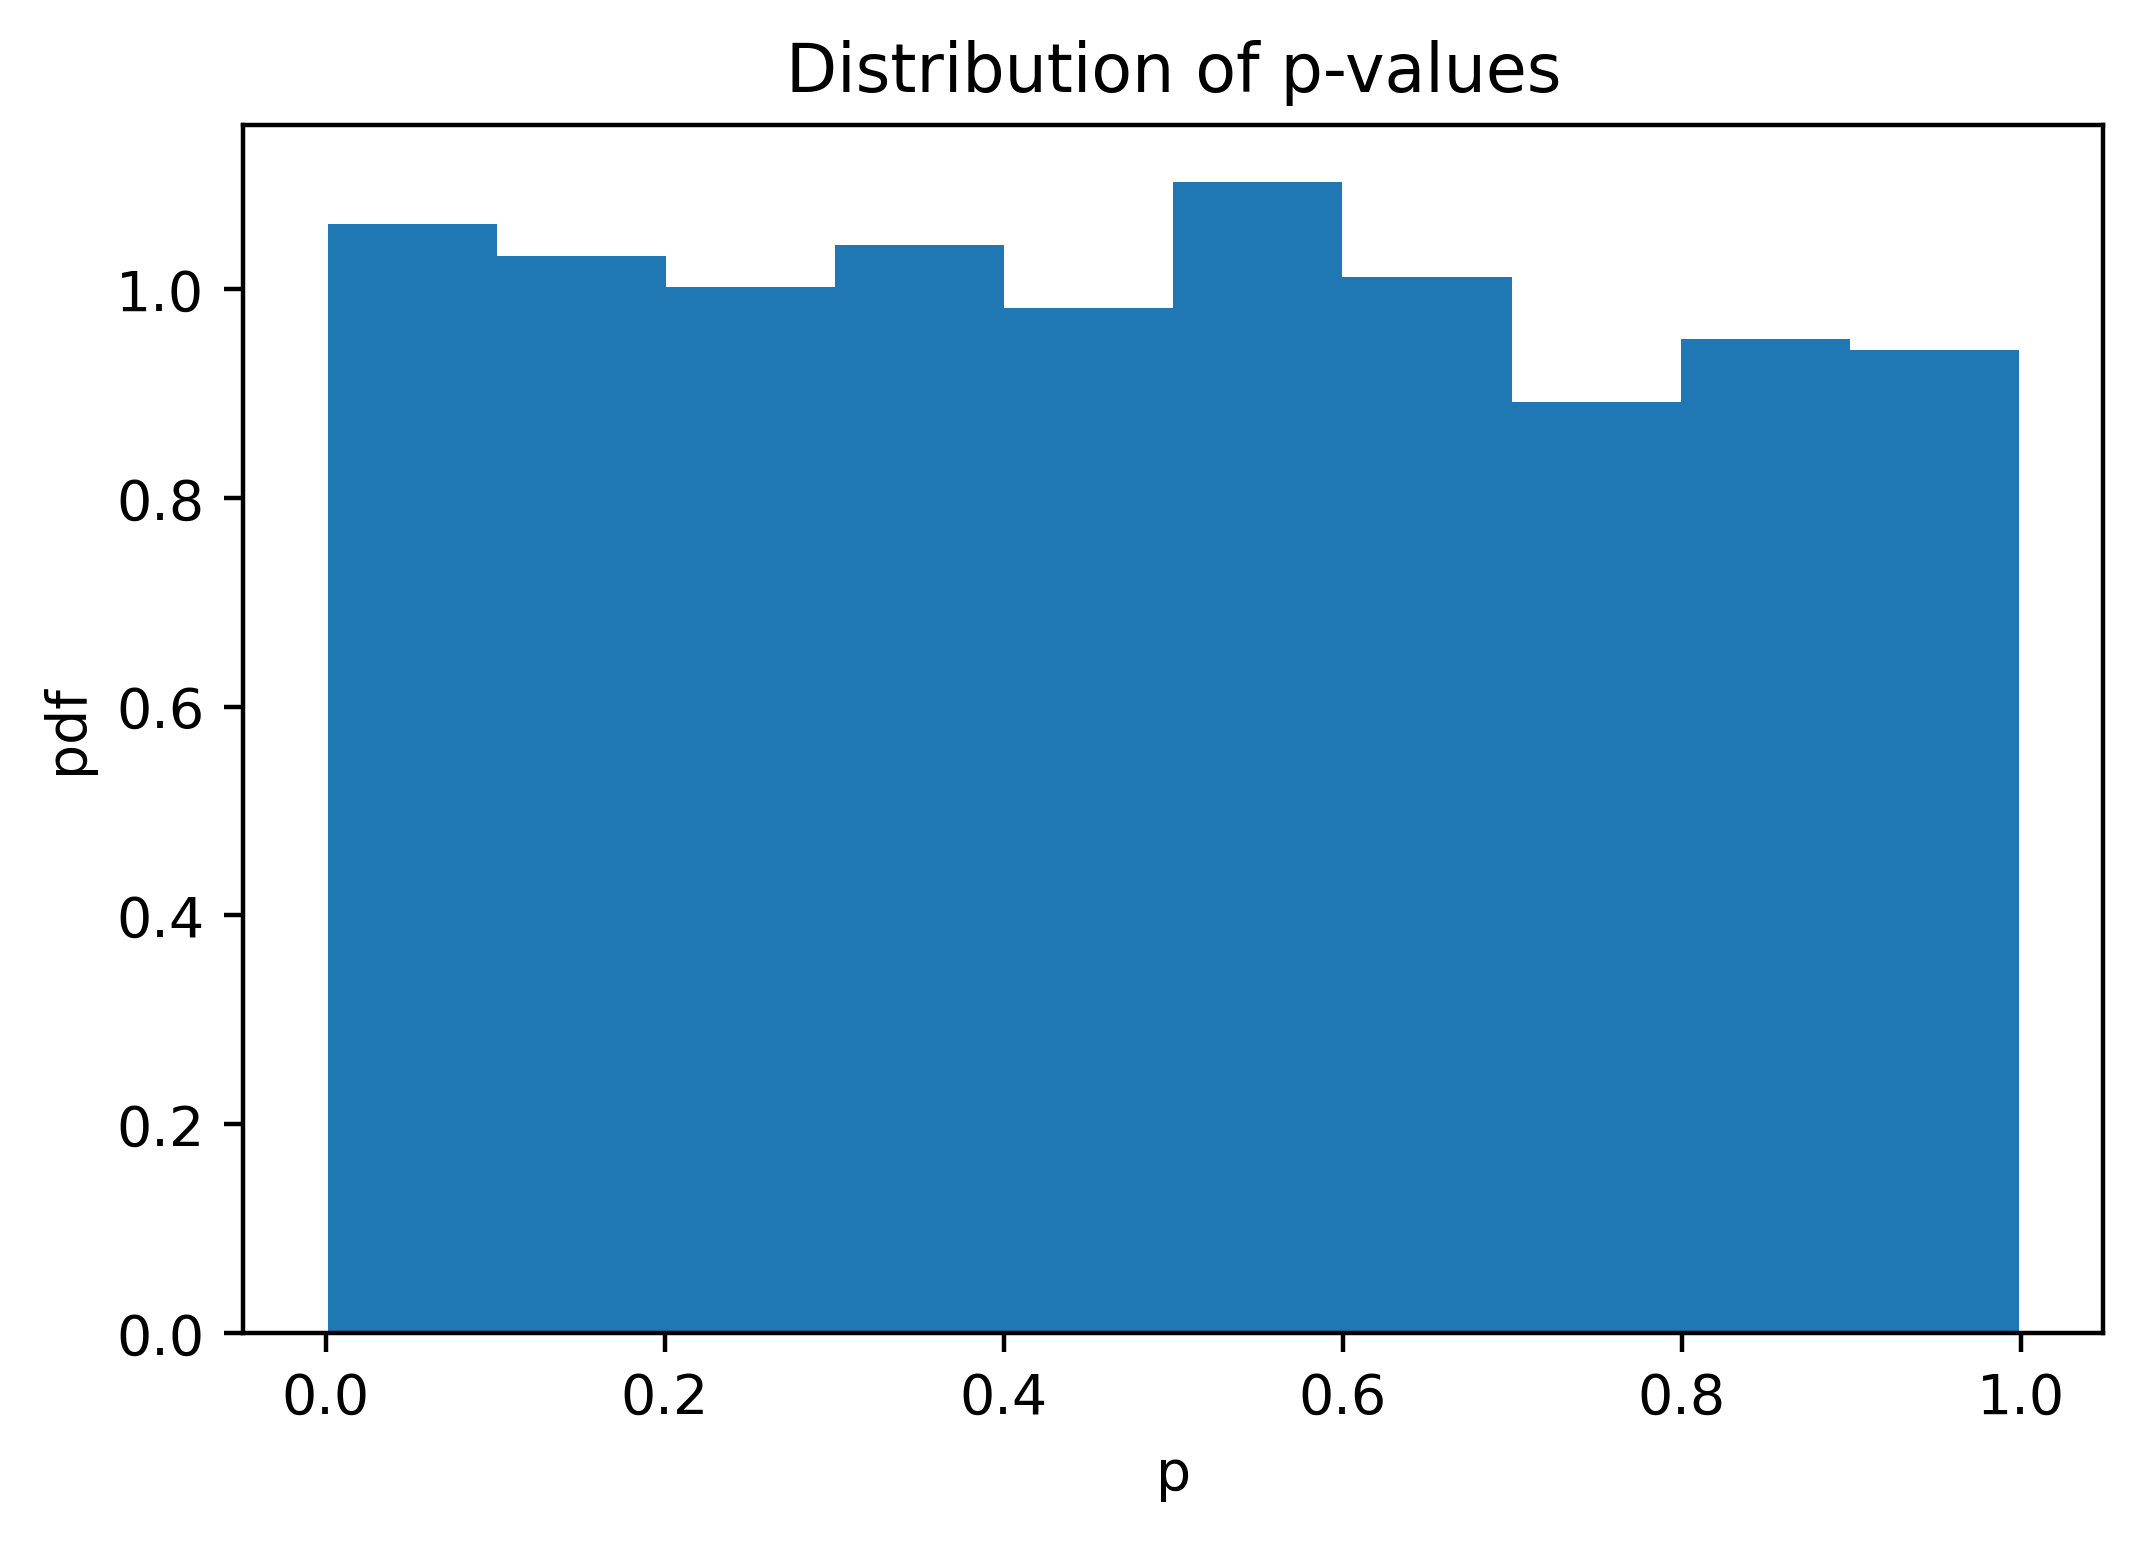

#### Dispersal Histograms:

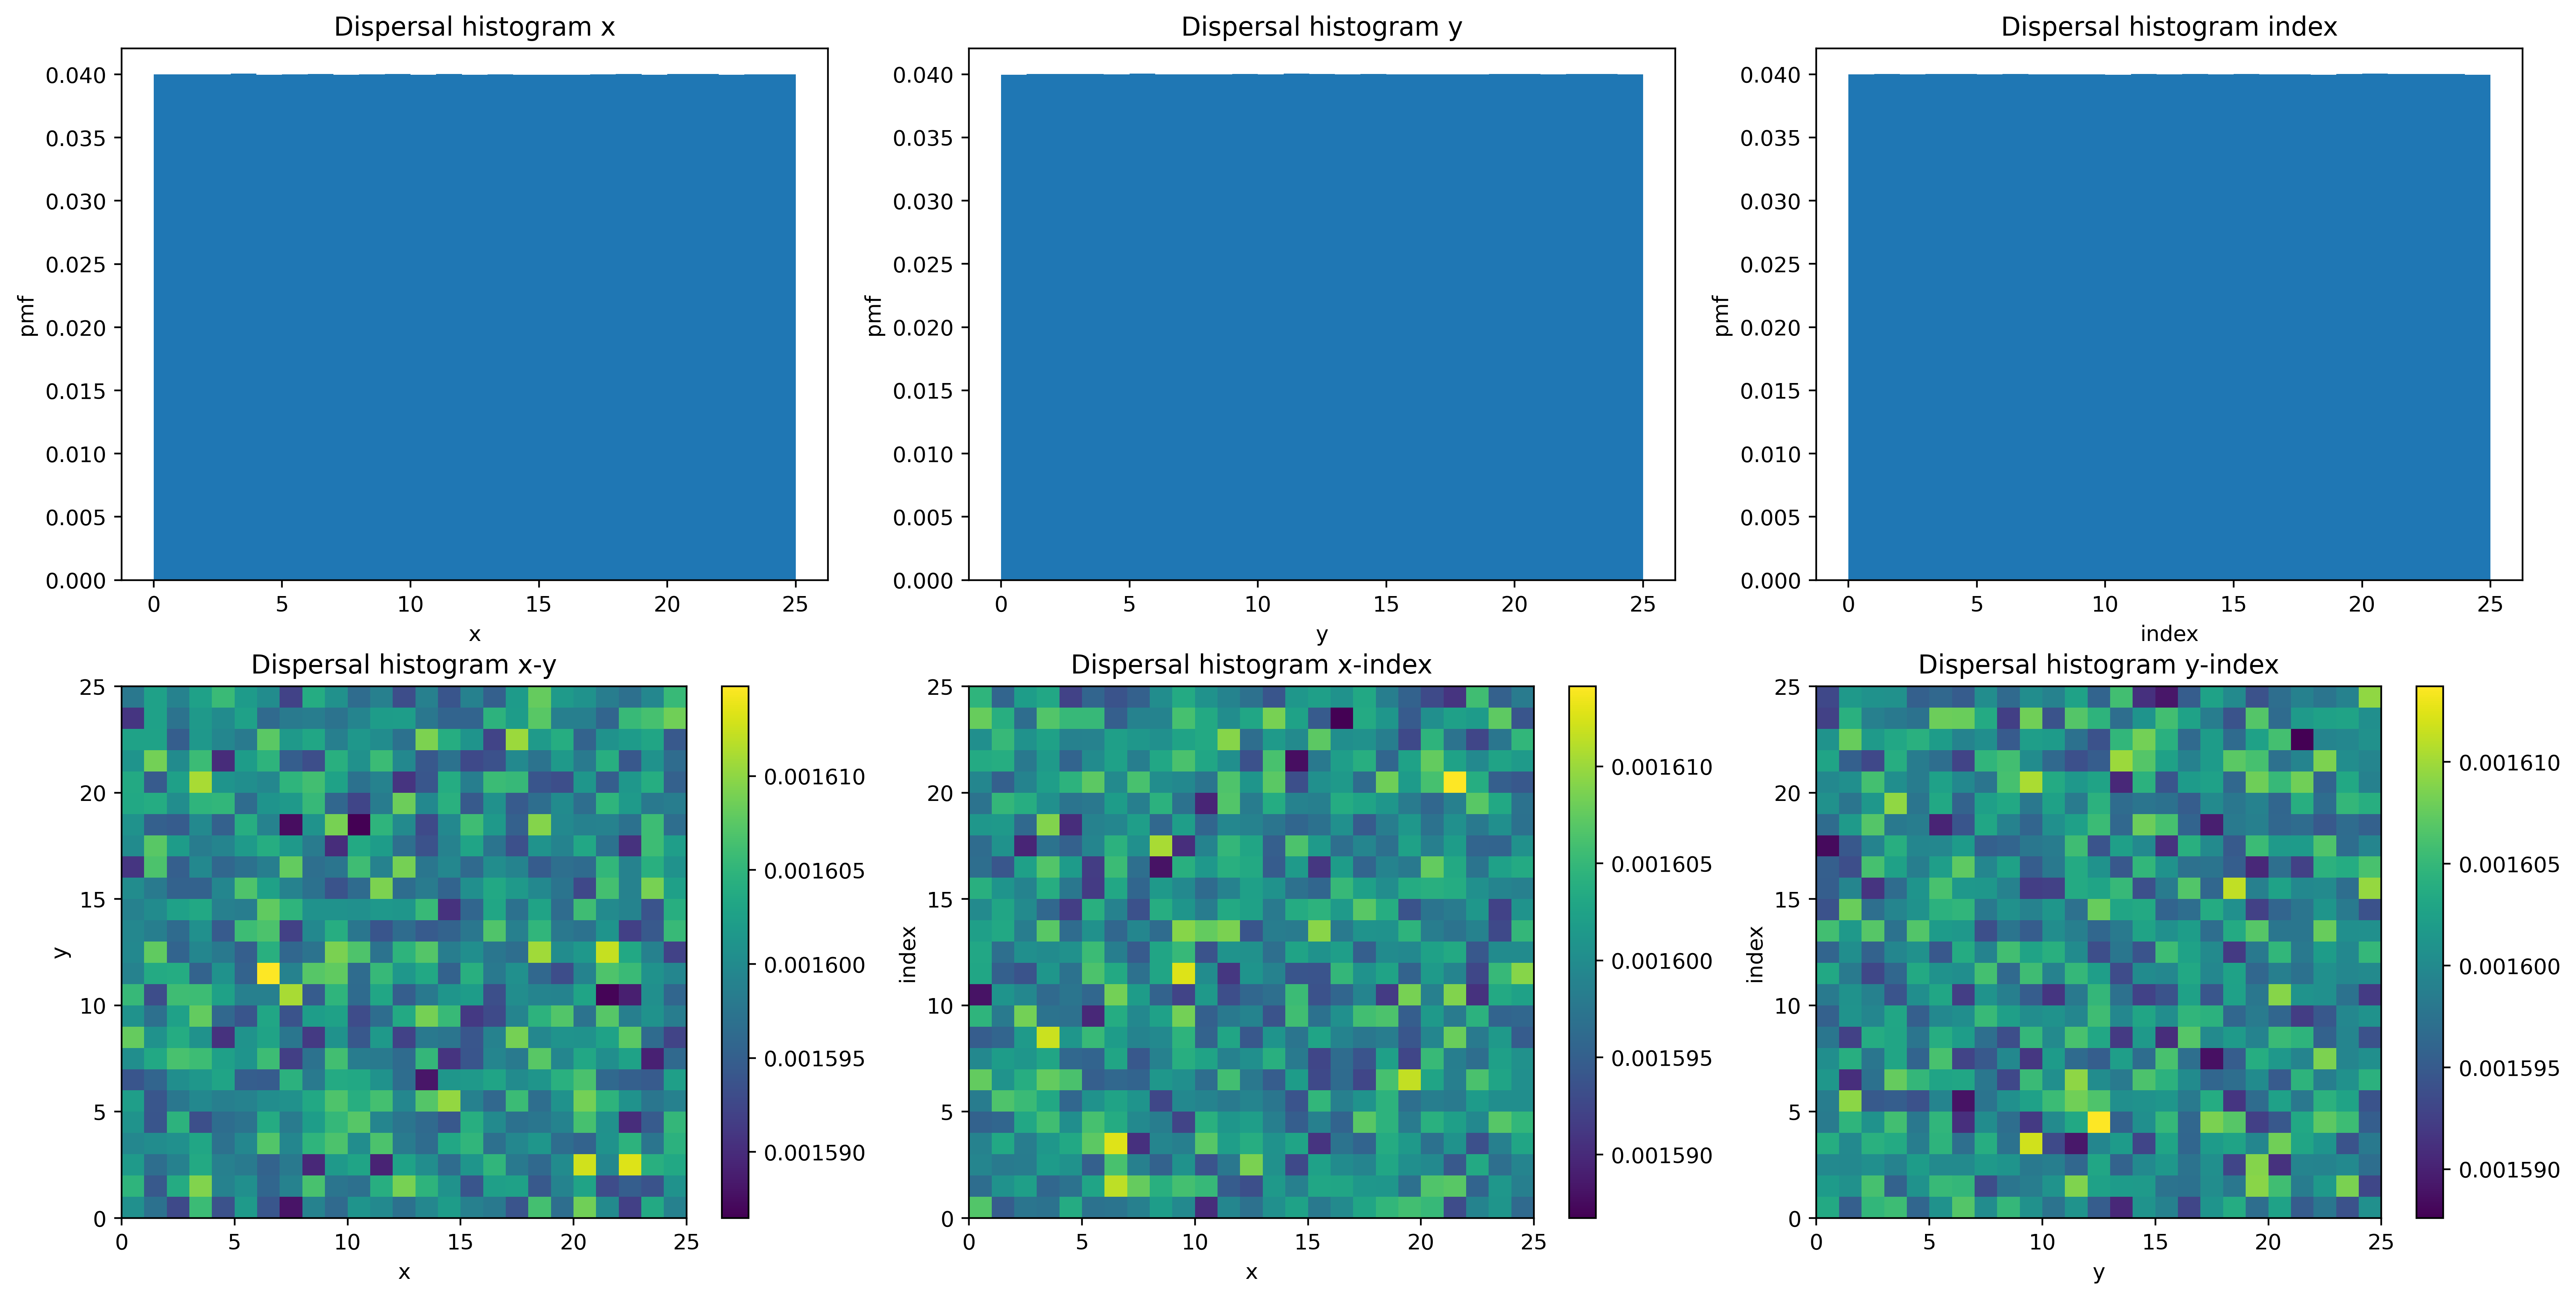

#### Parameters:
* seeds: [15278538094792959706 14432465702021065312 11376517800225793584
  9313547730135625620  2032530482912964311 12681063151449855556
  3779121703830305646  5735216575501495174 11472199414077694397
  8694937935881049187  5392489015351564972 15025968805482050131
 12093783019349918247  3607324697471138205 18290470425480027961
  6436568702515244273 13131389730091186423  1341048317969750477
 16300670841281683328 18049945793554231529  7386184507658352730
  3790923347257020269 11395874326983234468  8615020703997080783
  3400867625117961092 10542217618800022588  8283606707414963974
 17834326851329707066  4613893811233228547 14869332495031949600
  6949780821195294750 10442334392052024276  8122262046876093473
 14651147734220312526  7360378322593591968 16637364620371123492
 12517655436828874199  1849658100936191774  2067756690458248308
  2442761611063293867   970402108366677176  5284986065639632538
  4512744923549511106  9023857351316387087  8275403997500883093
 11075896012796993091   636362039380643101 17080848651619810567
 12642016724094276956 18386179098882582708  3400439695429083825
 11254561571073577496 17668113618440048908  2234866083660131595
  3832573856410437972  2571179591457813520   768588505472337755
  3447678524417491312 12386933560181839180  6896296157517525487
 17094724991449186392  7125568954248452101 17577684452794966812
  3344989594120973913  1029783521291546969 16828546487747047942
  6966981086991240899  6577849413795382125  8053426288433290543
  8292474778901540855  6037763483361376557 17961266359667463700
  7444692068063289153 11921985681117013234 16085180137900818273
  5553588283919894441  9766430086625256933  1853280386066965980
 16088117796936902837   501971569019804235 13870294494759054828
 15436199531160173994 15889686403838166037  9024134134905380158
 15054182397265626619 17022254025928157113   103969586188383125
  3740381657328119828 12604604013213094392 10829555698098382167
  9084081066175138146 11687022007705313153  3188264826667399203
  3055734512388986632  5669265565540670500  1064606757387816529
  8331207771133064519 10144912563086840732  7283817207983982604
 14728876498734969173 10869915223266154009 17751582817048764253
  2677093792930860760 17644230960307783558  3888088663790783947
 15421084380493327939 14106511479389375428   984060910719294556
 14663313040969098783 17620918642365537613 17102396947583519657
 14452217390356364436  9477806028404568208 11401746572476809945
  4736608937500715552  3100728907854784704  5686053438238777927
  6543424926922920477  9934420114244978993  6294171925945363274
 13432547522599891398  9170449830881517656  5498404929992449681
 17068017109879462745  9460446654337520496  1097770626644130209
  6506760294977579949  3850698519941718067  3685020321696746158
  7548419386647562492  4393682935845226232  8894184238261527876
  7601518005140166292 12952197379678139629   182700524181438658
 18110637213642815814  5073728052467639637  4815439277581730425
   940573371408329927  4684362201266044214 12019627048665211744
  3110173222432924310  9319825595727290434  2689039866576622271
 17598852631775214175  5929871304266333151 14238164096157194052
 11270240485334533222 13712007432428940697 15152955775641121911
 14603088839917396046 13735786603719935645 15996969027771771257
  1183612578792351776    21972298259040358 13591689152987422175
  8495561386545808324 15684838149543348365  8422545967955837890
  6024970445199367248 12894718790955785257 11669652343496416372
  9362987231148781344 17176186439172438920  1396605556705167681
  6738689786492281091 14650986425211881778   995437933477746940
  5074328144720250123 12000133781041232534  1711643725480753318
 13354378367202397181  2384494533285967405  6556076780760791399
  6385673265091798388  8507499679470673894  6563343463635320188
 17277163931800463976  5534223364045164180  7583413460010309045
 16069088651538215252 11437277146154189327 10279933170265987811
 13375588229176132788  5272401011478920482  3932261214413838227
  4136797987765879599 17754134875105649817  9932893441723688113
 17163829272220821204 11332497330756603782  3419251439649729892
  9934768013052090078  5375902019118085551  5817417574717716985
 11573976521005580141  1802580688978348083 15040765103574643705
  9415360464125176646 11658023237893179646 13023129305522391527
  3184929653706612404  3483296650280385523 15488359445904722233
 11882052314216252947 16690953395923354452 15259768257724461087
 10767431413598102713   646591886373823948 15052459352584340149
 15593374890413324759  7080831855977368868  9514561976888418591
  6045625599502326626 14138509976962002377   916173993960638937
 11532326476762895922   478130140065066771 14193908874858560453
   363620638651221797 16109660092303108189 18052881617292236844
  2862456478773412383 11058916256837460433 14732533230638001726
 10765674718966052416 11157454462577521883 17434634189459492109
  3996961100594851571 11550432391659443389 14537395943725283313
 14313433940825627752  6391127776116932650 18415300472931689584
  9941182349575499967 13395772175518980387  1349055422606624888
  7374065488269315575 14940355310538061081  9045953833203994393
  4098897125832483460  8034715369665864920 14541182334741766050
 14735949066846064957  4419178683405942524  6898657275486309918
  6919010905999945540 14424468404945491288 11562678517750439419
  6741107425847842686 11416291310561141292  3541098639404992939
  5987249048012224360 15572095595339942854  8762212877642007544
  3092520538404628149  8867123277940434431 17149175764883293992
  4142261512743313253 13779643069996912357  4950200331496004968
  9488610122655525346 13011946439645866985 14803683980130397157
 17474958346203072547  6585349943545452678  1282170989475318098
  2250912186341529259   930575284119634859 11266685281728455445
  4503707192117138504 17817535050509097918 12910331549943247841
 13144971624440283039  5792353907698031394  9231728820740222732
 17329271042854292280 10668323084562896698   460196876682345362
   884514287601854616   715520786450933952  3887926906733933804
   224972964245531122  7366415143413517093  3517540726641664575
 18056052073410654089  7687756082321890223  7817768382117515643
  6160380264816942913  2324525394864147880  8023270859251359804
 12167993295958314286  1080461170805323984 16873061574804832396
 16342745052107625350 10470445184075173773  4444242994408923916
 16543538906877275257 18001652703266680939  4908306987502824576
 15540299926894484052 15968957836014727997  6980588545914185658
 18416536000387603061 12685461148675692552 17201507260331430907
  8284714916987759756  3033444942854189101  6976221517503356044
 16048103398304604784  8164930787362700683  6643362672168546251
 14039471491356025521  8712533942275155299 10545737817718860107
 15009312501584931946  2336617203128884779 16872894275150654662
 11163919569711385748 18162997668652213548  4640866904280024949
  5876412819796712635 18270951588243235011 17879049121264056860
 17817842736770312122  7878280382735573901   684633061670218156
  7284038287799143487 12517088853953009222   182300848716094095
 10499062433501199204 18358006143370163931  5839607034713304183
 15086067853720695892 12955370062691896317 10927968648548296222
 11610442182123192898  8648237868552277653  5864383535563170669
  5978161303562181259  2982277508108085775  7285016932020078331
  9270687405725809479  1684600817010535822  5314660915099315593
  3172343979212250785  3718156266267858848 17022728208801318887
 11531039085765986373  7512522346046476424 13736108637489727602
  8548583058027180588 12781022210580450164  7767904927139625691
 15327198712998265085 16979112712393626059 15391824574974001871
    58794406428263575 11833841196980671436   389198413238967657
 15841117095899952978  7210652075391162996  8901726834673357134
  8920118799206397162  1168729422976520304 14708161628128595020
  5084898585838263456  4791631168859163902 18337860717191908187
 10839727687044822322  4377496471914749982 16921658615359210755
  2664342355032405050 14031418899414097162 16252934878110931962
  6148885766333620377  6934720092748100583 14806347133567258522
  7729057462530545638  1653979157568982724 11029173247391826851
   274539380625218674 11411486990681254350  5445694262115557017
 16794652462711272160  5136326500676663895 11010827393532992728
 12698514189737947657  7905480674766847006 12521863734819348935
 16232482562340705721  1505286019888505240  5666050943692523267
  7965843153866201752  2376257029467198779  5806956503390663325
  7585599387751916336  5952744052521641550  6512790546802476207
 17529986508343316304 10957535511761359072  6022443149641746111
 11711878812456899310  7083205387538451298 16291962781253723737
   922965216410632869  7695847787306515690  8089644316826107019
  9806607465651834947 15149627057134942306 12977816449999697048
   988189718156788634  5883207038770390018  4280830828217496102
  7086020946572083118  7810062101888243316 15775648774433905751
 17904932560476668245 12523936838746545416 14641341578281486313
 17452200860309690174  2713568622240962165  5196627165006375729
  2707387303789373758  3279778145485524433   283017319509055447
  8567432243154722994  1806285804037713027  3531653888781610251
 15453365996304574801 11292808304526915051 11959924810961124494
  7253849113132653792 11186479752650031084  2334802897492820700
 12415608000310786789 11360125789615186731  5957841973307652602
 16192805329510685294 14224949216006979863 16496354233083307370
 11646843924420498944    50869699916282639  6807892094163095092
  6486406066502963344 14314450359947456014 11060733200464705075
  2962289974973954557  6187299098189419526  8851827505049574544
  7480353423967012187  2257029526458702286 12912414323722581905
 12995248381208069012  9662719905815977785 12247720807997835676
  3987412926202294109 10340580427075895192  6972872942251277042
 12817116223772837180 17324672675239613248  6276794350096909234
 17383896083165591493  7686516597251084925  3987476272053791608
  1017737926871222747  4939014725599981720  4017143774793800133
 18004631820146212200  3654857057358798734   207671699543539489
 11779693801263689214 13620734812810040874 10068239150554449703
  8067066527842229259 10839257882041788275  2257934765959711837
   380947700016049549 10492603153250360388  8849493814760657934
 16556542119353280148  2544710321694714246  4568857863086425369
 10263592151760491525 15373147784000868169  8826966696959252145
  1223789603228824672  4154986485811765490  6878470614242843414
  8618943107826426243 13762305710314117556 10196674755653025016
 13227184684928527103  9259505149178422198  8570959131196543442
 13508667757863372013 14802970227121695021  7226891052012976001
  4027909691516490024   688363001575134277  9625383148865835662
  6410044756932955257  8643639809226682239  2725471293205049766
 16045745525413883999  4643136973296224430  2377295761308321856
  3766739895834427217 14092042706687514926 10565073350725827696
   658052773900603174 10923239214808006522 15182176841812359821
 10740982290283228176  4876011413997511609 13128199245019743977
  1156727985330228258 12778560804163575843  5179063733350299922
 11601245562304868430 18026144358107216859  6031555785718835584
  3046353737266161720 13085005752887815396 13188269729261680467
  6440494406551162220  7264882758965804227 10535102140017393210
  5979002366677168565  5190554545378930308  1316478253422161679
   196985970913707889 10361533318808391080 13040708168585371649
  8468295283442824245  6493524069018988151  2692709597318590203
 12014504754460959822   785510371581947611 17708132995967271125
  3104645743032860578  6400749621797286944 12443055562868141400
 11411238110963434967  7776623933981295185 11420936934456820546
  1414797719854664573 12508105096725684318  9224906503964202530
 15750671615504292662  1101213783822475276 11390223955895452635
 10376171713300832748 15871134714894046208 15242477618772017293
 11114363036909074518 11620891884997026025 13293533214345480096
 13114646665343706184   577533159119795100 14472981977047072800
 15903707725266923189 14284348404090504251 14032264847674022664
 14032952735302820462 10406701820629885895  7422865817587641903
  3081652921528566019 13024918377411911454 12888770324121131026
  6698549625586785639  6406993651269412066 11722700107334773905
  8790792187555684805 15264199266536485541 15660483939948893759
 10513369312564874706 11678530324590393478  9498766403992317483
  4479799106447093715  9220135165931104908  6587486375142866556
 14252832094088255904 10901946938503432553  2593182772461351490
  4946026575461639611 18170695810769646939  1663739647105286587
 14321648616331827957 10154298462868203905 13893685725581455026
 18216820831485509221 14112338437213487243 13537917429636771605
 10966289435480478819  4153410305174114499 10400843148280671818
 12910476510328139531 13179520761903911508 17985268813571355094
 15635024390526261217   173355469029816601  8218198766837853927
  9553220574565969582 15108718266735309766 17611850724189336698
  2967093605945138319  2349413167859649000 13507045661867696381
 12650927134580713534   957968878903039591 15289472233090409872
  6767080719830582181  9640369938396802992  1251920447559794939
 10088365625423628955  8879985168187716783 16799571996851070189
 17029041368442130676   441182462280027422 12155355517235223981
 16768795014481531237 12678790448625896435  2111472913323708550
  6389818286080992179 10625120454817731732  9333591071216131465
  2305754115036245462  2561567220161361944  9265578648586238444
    18849563366400567 15443043302179809034  3331810317528031927
   329343962165528668 15108647465590770009  6150463715717797887
 15082044513162384104  5565874804931887051 16213580316355378060
  7602874547889579808 15730908338743633425  8961799666276441739
  6084002705984787086  5073403510636655167  9209411539854616649
 13330863115248330357  8626893310026370976  8344752960035512564
  1496049494499061240  2870952508486388241 14715361322159945120
 10315716085854348570 10854744451667553883 11252589578258710804
  6236321294079400767 11152046332089315905 14487713683725123457
 12476126378375203912  2203235880884296670 10205227944907140304
 12220757597146171541 15983789834832573093  7735071221597233932
 12224444907758460111 10967567307967733820 13542803730740892464
 14433963357512408367 15336451667274971703 15632535504463793416
  5787413666625975351  4699640731488377427  8235483092671459648
 13095300229407416709  2628977338702384043 15912000725601349789
 14805199226698358893 18201602324739687782 11933903831615472243
  2289276753403381480 13177029884285223760  2740346073178858515
  1737828894511527602  3704197562611411023 16760327247564511095
 10175754834257595881  4422761851347158529  6526913143390358995
  6627478194231557517  4679221487739344310 15212094727631373516
 15199733653216789094 14987719215068220390  1250262489392201917
 11971355041801976181 14428450667089887391   141385179644614951
 14463035763727953638  8124925811147504049  7821918433343145399
  3091790232386734939 17109541815984180894  8067282295583539747
  3076715516997101311 12569950773046061605   979363161124663307
  3074037142204204650  5276920586691714740   189935274229270286
 10845327108349260362 14729639421156468413 12148527974316696823
  9020825538214662016  5593177725049477051  1587693671755491428
  9012483198130265396  1503533142947721677  4867388762760178621
  1004770503091321219 10419149088047173725 11836654970252789534
 13856510229116518771 15258836370169104161 11929397090694769692
 18348797608810746884  2028317108391093047  3923097972366640968
 11363517319429463230  1788142876010304114  5304370811600580076
  7437538433933285987   520595240117734563  9008855118221541836
 16426611035469476000 11493061612866409820  1096149232672522570
 10025582773069312793 12539960761245642098  7848122327409782791
  6437989344701630398 11209200470403115008  6724617483621595585
   353759027584850838 12568762069541543527  5184529599059286766
 17010434111852023139  8606717579699640438  7940616492197571881
 11626669342919903740  1802887036334557896  7503900007342786144
  4566226689405446405  2093106001772416418  3471500313831330636
  3858604178972980664  4178032352501743568  9704584766169346324
 14452875934379045863 13910544898770886429  9020904037092933835
 17777516738843125915 14994610058719954313 16831704100244682652
   171672187678574629 12037589292236184653  3412195032851217211
 16917955716840426416 18049209612664887532 14184699866871063554
 13750614962235740172  5615209082555059773  7645847885857664015
 16511278638622161168 13614600820160352382  1480326760288401577
  8768094208127856491  1390182668891987967   226463779389366364
   124791441702376880  7403076664567082283  7284415714351294790
  5007662071094128139 14191157591632916871  5981195888309483659
 13484456168445688204 17734115675633851897 15983772824515789932
 10574993046295054985 17149322140307553702  7924229377103370877
   840130653734135151  6359944428392988738  1877175463916056970
 17232834559450039937  6601964517564955935 12722546317902047224
 15398441305743009382  9873913348082774616  7370641255982652918
  5212238566358747293  5449059610816903502 15657166595336303043
  1511522752174730761   768636389601237067  2867149554918415482
  8984618465044192233 14664313936148817692  4685154260656347936
  2256827834378628325   843438035228367765 10351555351585525374
 12056261100436102020  6320149159834832238 13603738642055491920
 15611754208932325187  3140833799517950316 10827905310238431191
 11475978829267429148  8574677182882916419  8987214715933431737
  7463589810741900780   598417054092256609 15824696460262306394
 11301712451655107098   843824791860449648  4434320723290163109
  5586151844927024206  9877081610463079207 14909795022967639984
 10453511577156303145  2115579142230880552 12673528372962003441
  8208386006980973618 13285300089404391052  2256172717790490439
  5193149367901235262  2837452478544904422 10459709051154283843
 17751032229038755924 10675834777906981809 15532323913075477447
 14998851124927993274  3944681902029991333  4343459410947855096
 12292771200651004556  1926440135183603261  6931249180988302025
  5273216557149504329 13136786099639765783 17584086496638049535
 13989546927986778970 17290038883480551699 13046750183958804714
   517902499870584491 10092868423083225885   915859130478113631
 13952439081505521429 14645055644236671930  3499192392230933794
 16681661374988600172 17808426603517405430 10258870077651803403
 13992294753352058718  6063595409816581534 12216623303481060844
  1021297294074686581 16075816198103945947  7903020690229783083
  1308021933704221613  3846152213747966123 13086066834093860132
  1346027528123032487 18064566218161143876 15818169497804985379
  1197611087540475150 13078341257971072041 12983260380100854647
  1365050611270562872  6112342231853112996  6116251811757091931
 17987759870333370346  6216812932832157709 16274729493577137827
 10747218860855445198  4144777205018376191 14301412193070045930
  2320583796362426460  4314632715286818480 14012353852323366726
 10587248499180981048 10237058053333972658 17775953290889385555
   265671446150957984 12318095108169032093 10222742788237178007
 12792532899325210749  1312848183545729185 17738666294731788093
  7403879161621660516  2391379488552725386  3649555231682170604
 13457290769985860120  1151537462290495632 11673959013149604928
 13291972546188068383  9605701331790081340 12207219699384695251
 12091269383960994405  1422371259657457952 16947002434535060412
  4424642838195336124  2270167032174651063 16731091598194619264
  7324917226598743273 14411859125360801243 15729025072915938475
  7525684747205760901  7299638295023290161  2405467258522504347
  2480073670175005281  7654096296909444125  5459822253908456373
 13541917944689781321 18222347458796108668  5810664991204955090
  6201257261499731041  9807833396143937726 13127190973197214620
  5299756646223068739  4890550401656949585 16212689134832524217
  9634409335195753222  7602311596713735383 11996618558594513980
  8980600214862459899 16645736617049907801 18298631341650561842
  5039196740525411355 14454548545426061894 10756826394185706803
 11097179477458445523 12950747792367548108 17485710984788871735
 14975205326732472075  8611466983920181529 10139436399783880973
  3956517887074414242 15954111688535409933 11440283919016747998
  5540126643142115152  1607748194555255112  1559272345690570397
  5116228029073454265  4843068509268112244   637254323171249980
  2493928316140093394  2648873523033287215  3038002603862674074
 17173028989116396185  9382026757482359141  7153832096262554492
  1811367419780415833  1156025614827414617 14119752943238031309
  3439559132087388899 12907444333294492328  8993777785519020594
 11019429309852317392  6071616802842444108 14157111734482399961
  4464659745428987176  5803196827421568496  2958324448961999475
  9353169622794345130 10125721037389706303 10855460215117698665
   271759066367353232  4139645701728031671  9869171133615045579
  9202219249903794369  9168992394948384479 10757834073509364168
  9101237135032492824  6228415006300780947 13292869723689347047
  5513777286146536203  8141427659903560138 11165221011884816151
   554422004808178745  3179018041300400768  7197098832464390555
 11238187308131171324 14754774293538663907  5506579666344976192
  2385407293927347612 12681789239365545344  9072217097468047812
  9381272599991085236 13556305818590461636  6537648610791560989
  1656461800900129870]

#### Configuration:
```rust
(speciation:0.0001,seed:1656461800900129870,sample:0.01,algorithm:SkippingGillespie(),scenario:NonSpatial(area:(25,25),deme:25),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:35<00:00,  2.20it/s]


## <span style='color:green'>Independent</span>

#### Fisher’s combined Chi-squared test:

* p-value: 0.14657163878664434
* statistic: 2066.5461676786354

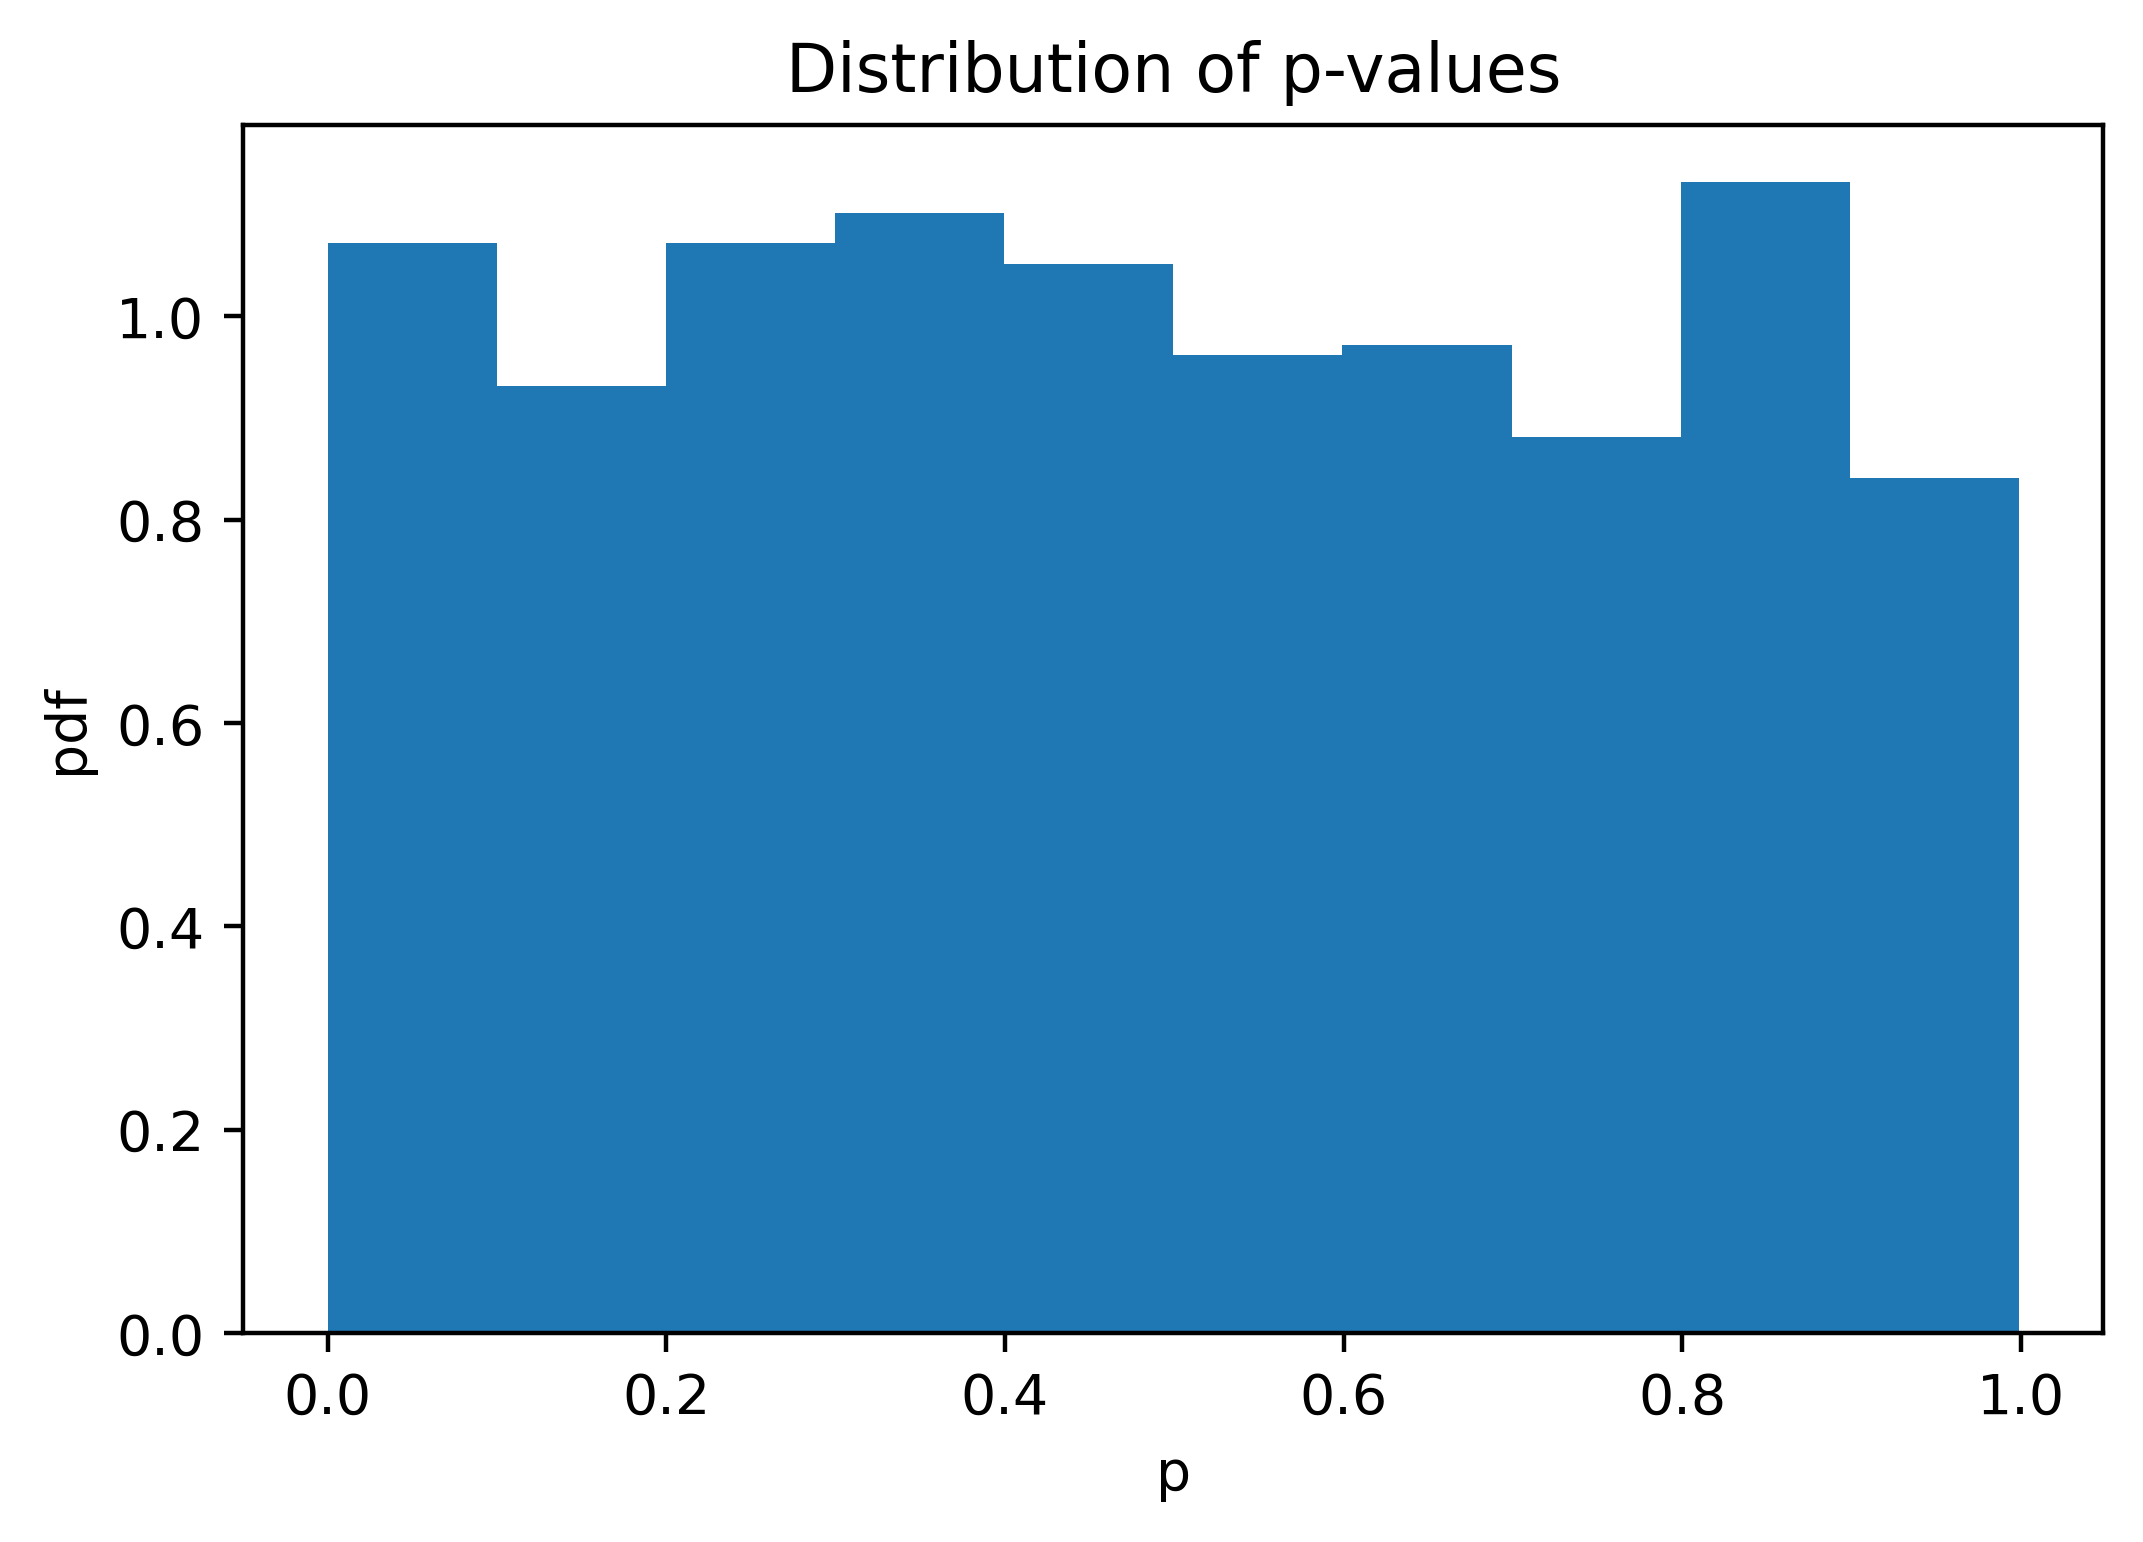

#### Dispersal Histograms:

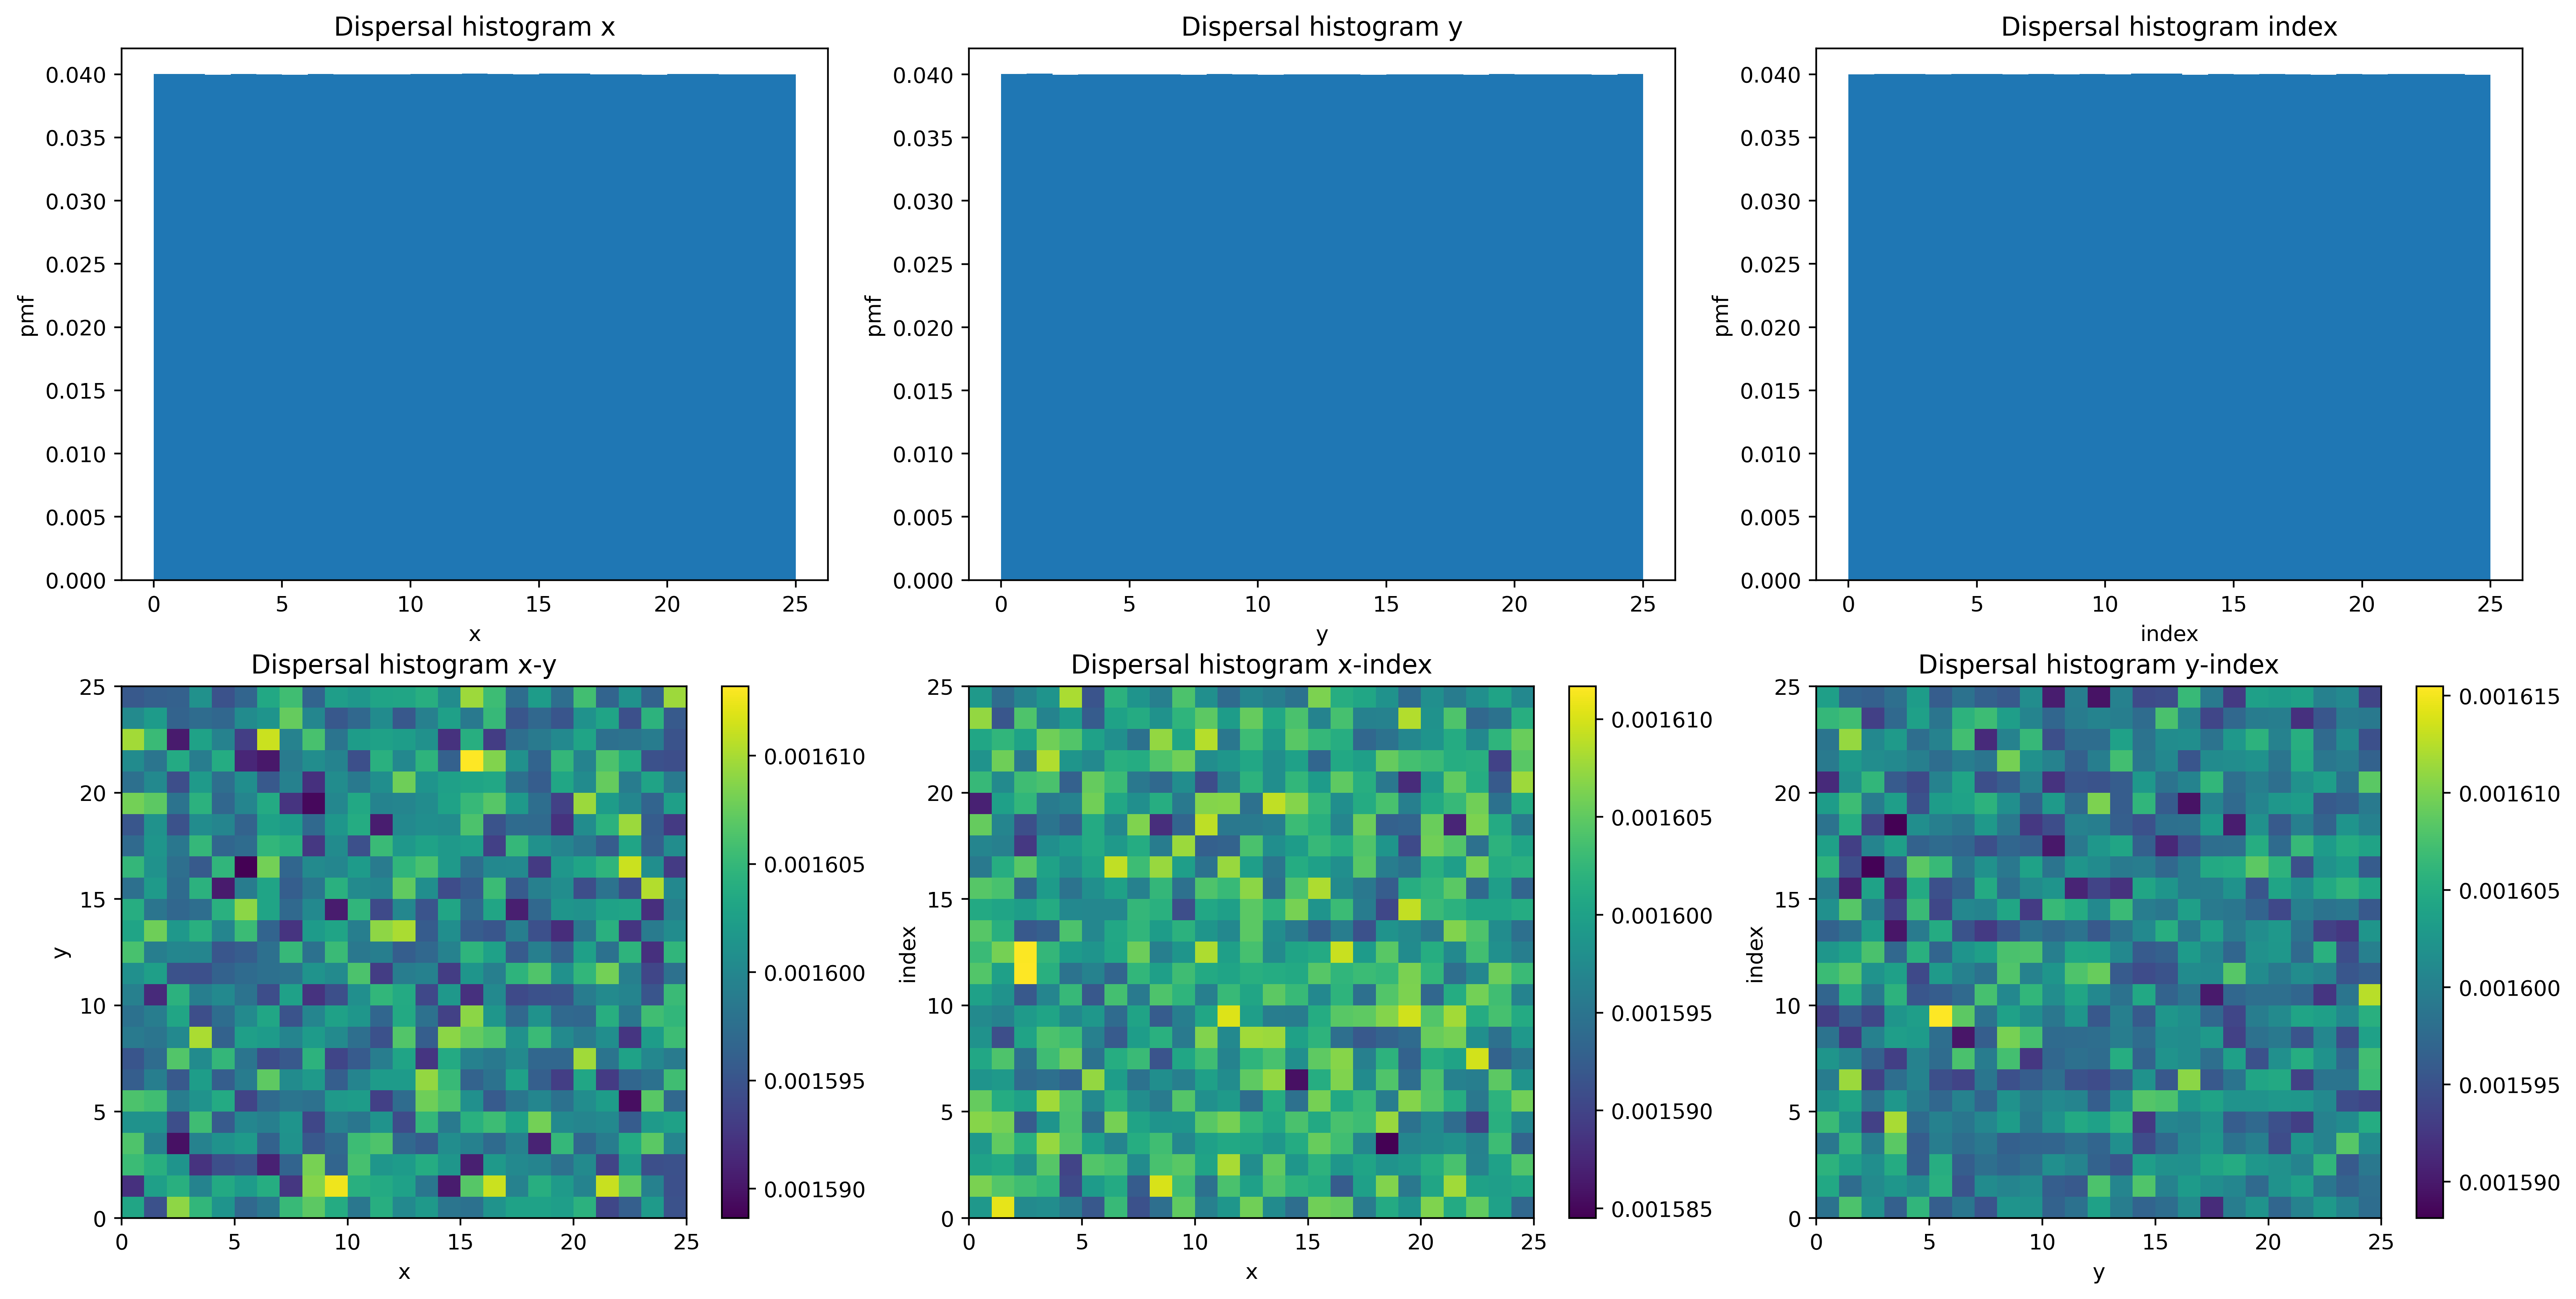

#### Parameters:
* seeds: [14714026414088412027  5885799201499910008 18310961000576122424
  5937435902915885034 17721790079871843629 16945715251354327881
 10999750924766405936 17887125504853310797  8571829569227647836
   283511998235790510 11462985888621055906 12418000776674522952
  1785902991638595456 10349465808845311531 17495108946683146219
 10657990726336610117   497922329767112261  7027971250572928168
 18232307591327505683 17965154885344833256  9149828276290346939
  2739795388475016526  5884426304822861111 13361841994685012287
 17755989616231632665  8411729338741285736   369097810815084905
  4358540234619009948   231025185818638660 16841082026621029852
 13792657268928656219  7041895504068799042   946447642527328269
  1063349486487594779  4954441261991585736  1677919759588273569
  4059164999367012340  1997121627362398468 16224399280895096092
  1716815571880324730  7101329220258040593  9401813777833665658
 17986721653609649520 16322928270458201346 10068712237122882207
 13873473290978941995  2139874804689762229 12292697610235552060
  6463209854510825732  7927992726883430605  9289631861430769232
  3678798697169186223  3316041965616869991 13266877022501946538
 12113626066509011376   887943529797178955  8074684641721046039
  5230128503353413397 11940588146500017300 14133156596895697750
  6794242045998863540 10507437285186985187   869616809973274031
 14064919645919609797  8513808495449304642  7971203282117241329
 10023018250995661006  5555330859256292111   447265895827992888
  8866920357215546879  3618181873063217003 15558205765855851461
  7824364718493407273 16421781553764601570 10595360385207040246
  8301487066245359749 10535901415431421039 12480096840989057746
  1956352215383438591 13041733386959136906  3212301337863288063
  6076903518569485947 12832922925540587063  1048682621636858850
 13535769329644753944 14336698906734505541 13529475312556456215
  2501040404846453941 11882437554530850975 10542414028365930145
  1685037254792986237 11184621550852232837  4025306103745082673
  3961859199466116354 13593164352602719843 11235241989971272206
  2850868352041123036  2311523560187967661 14019168155143007923
 14094158529662161506 16928596739944336196   796830139770345186
 15562584292059528690  1782661137115619326  2096013096550305853
  2207096939703087113 17497302697869390825  8732640039257308395
  8777937087796348850  4195547247509400667  7182650628569314472
 10288000177470226456  5500018049902838601  9397879757885534323
 15508162078206755108 17336438338807056425  7823805461302837785
   764338842900036106  1002619635104617121  2522082175043579963
  5120668480973084216 17198521846514219993  2126779178876431507
   443054459349884994  5950898965626288366   973825387259136099
 14363471256039650689  6669677358273770200   172376502216638985
  6362435083242621699 10789801118655881946 13462853474793992633
  4424024171813078825  4001824694634970808  5059266026703517941
 14200311496572432907  4345557433815808706   321313628805967599
  6048418210297195527  9932293079707291670  5401640567171250643
 16771999613107824435    42756500366825470  3026540298221323609
  5793213984745204948  9971942190764456370  1029103535357344286
  5892534104883391969 12093729916323225389  1086820221845825846
 11309553900482236522 17091459676432350235  5248514133680226829
 10450009884499552636  4628686621181982006 12459263008716023324
  2176256190395180667  9122431838824917328  9509506485393016565
  2268105839772307342 13733698787236310095 16676804387727872232
  2752209143008715642 15648834762490402728  2160449875878578360
  9637090114164505088  2884772425101887825  1835004472886289779
  1977721675727020424 16600579063320948495  9592490579049179347
   824336657719543320 17338965514227408742 14692335967687403693
  8696212956244547285 15482952643536698193  1880500191522836332
  1023139236384757285  8424965172286032078 12720801524070492036
 17860746997244324937  2659471981551734667  4149946132785916556
  6389953660693692249  9730899073321123193  5124351910884004125
  3401600490522653822  7837424331119830273   256388035924985305
 15441901018823205375  9240508214610736214  1840759640342821486
  9768511083827816825 17586693554247180649 12434875999314381215
  6299290366118746951 17345213841837296768 17130322094740111483
  2701331630519518755 14977094023580170315  8834084159900977892
  2495344619481820523 12134964747942299201 10037393323037757774
 16377567211042538142  2950424518644190271  8989057738408889837
  9401309713290716822 14730953747484630586  4315943486672715750
  7546707792813203262 17632036302043888527  9855175550733400994
 14741204382774054333 12790673883828668509 15797660504514442218
 10973471421746866383 16056539210234268938 16920814620662050899
 13782262727675994169  2122877508130823448  2146863003697301513
  5249258830449772128 10999293512519542884   720915870471179397
  5006112107793700317  3362933081516252789  5963438768801414129
  6301628463987016734  3949992438591938851 10735274746427131915
 13154888440294213161  7000914757133905067  6578033817129351385
 13836698332583036221  6683813417239499041  6512174300530001869
  3113034761927315179   851924465050139621  2822369041561966638
  9860905657883894289  8828710634648504783   220642772722606723
 10498699354294499406  1819657034530088106 13997957640083366866
  3895186602809686002  1933025861922439971 10630966749017844642
 10881231886776661684  7204851737967246302  8046724067215296230
  8927684872912187666  7246911680326061402  1516546173234233802
 11475135678955342336 16285742502295430781 16618045433559436601
 16560036041084741424 12860824329323931288 13568673934256305491
 15263437132628052557  9891846904683210687 12219788477337510557
  4561736179969641445  9736879601011492973 15317706819284254393
 14708838821095301347  7509739464670058920 12059759456150556483
 17821456673827145348  3186226149394306109  6486852968882886497
   680837605063817935 13096488833667532254  6290051516511214199
 17301283314498391109  8786922616260317782  1071477098577348106
  4710073938564171338  3472928805834227892  8476984023481443804
  4385336504843235870  7480687441065476972 18352490771518569785
 14394894816262124772 15218762008123956882  3575174267510845243
  8724306088541571314 10542359098475495696 11458613813657794112
 17246135297787803722  5656097780505701108 18012981407988994544
 15066804582070256051  9683253490188283011  4993145198067502482
 14210417496262653753 13001304698519847377  9763134405964244064
 14371972892156956576 16023392435647898669 12609211859824598705
 17451300455486276530 10559522334675854788  5098761516048082384
   417922833260676435 17949629159712915843   600974814358851709
   668088156762647184 13494090389922618332  3713343696642813187
 16537213734523263500 17552290265003753622 11037276376765615836
 12672083747970369894 15129429858225924163 12525226113202579826
  5374179415635564599  8574154459143607422 12746252433786246714
  2950888232885894183  9914764430033461192  7228225091113812288
 11956915909189024562  6440439034684889565 13365236034216588666
  8345613347987117345  8736320374138314966 16766235308084933759
 16205576193081651157  1661573515981083504  9255120348001372618
  8614909534281540296 11142435327480663519  9602768690390479395
   324871496788430878  5069225470456369914 16051591554081481123
  2606456439121764562 17290173548657680486  3923305913838354169
  5274573068538202338   218196562053995136 13326326508714657282
  7036092294510981814 14683457166225655662  5307595206063093418
 10228202499754124359  1035857177013703964  8015416811162262397
  5497341647300227089  8227932260037198530 11642217785227941116
  2641154285357398078  5674865460058097693  8194177590399220595
   794719830722991714  1096417716995372628  7387512526625253295
  6360731846494618999  5871221680748869956 11825862870422015831
  5113758754069233556   323381618296682996 18346377084278313985
  2434686633219801155  4754594053174419564 18221076814165724814
 17992144728072115104  1630629927408930293 12240643970625781287
  7317679070815909804 16059255438178373917  9968328995065999130
  6948839683675145265  5192385180437251057  3003796637277185150
 15331855160024794038   487970883458173426 10818751809258111589
  2116438135420264161  3587846805437223683  2140522520266225030
  7647673275061952969   385129892756505105  5280393218521196887
 16391283300603888978  6255620347986309842  9051509195139986997
 16826372040133611048  8086664991695878330  9893929371395091627
  3921775202570417699 14265981631598728574 13728261411253367743
  8594113868612990358 15028013887640764368 18012686810525887801
  7943901807239260362 15553933980577878516  4650144413132163960
 10884067475323292175  4693877717401091786  4892245689182067318
  5394016304772846183 16695013791595397495   762354439524914660
   127967863031739953 11728448323159034206  6547491402884371365
  3343374541768063101  4031493221356457166  2995657527004181081
 15545491558985829728 13343647943684130904  6007909583620780726
  1686877237634492249 15684792786111597332 14047330521489854784
  8949895028918227140  1052171533732529449 16709021881405829995
 10001329946567071849  2178620987930054354 17874015061183689620
 12443118205172113089 16309124629700643981  3499271172463453935
  8001187054805141149 14374719310276153369 11875587424632021004
  1218880988383385109  7006063182218573112 14440106026847675799
 14967179368312266298  2173648469103551827  5007474902630736588
 13156986748476920622  7792658709783731302  9029206825230621316
 14484659578270760205   640881070664111720  8957147828681653169
 14234174407036775873 12808285417476326965 15245250886334421048
   999973533258512092 11716506313438402211 16603143679238397225
 14747475309437747039 16338573482403231034 17946043769681417971
 10603086898638305415 14692672179901260370 15887126218746932601
 18080957359893541198  5325325221122554721 12040411786520366784
 11676434223899483254  8277689873039483386 16204799762873663406
  6196772111716117209 11718421002989994307  9038197190943208616
 10942704581541032257  4397734570708402020  1986877595008261159
  7663043457017425213   525652343352688600 11692967470128046282
  5999116186279225718  9467002314284494335 15254455376329576548
 16625676579360876683  8978644596415239046  9378735664933029097
 13611029669948697009 16480242161296863557 18429647276132392157
  9131773874710878061  8616944437111632758  5177647519097034130
  9541086547121911053  5914132170015830312 15873806564484996794
  2972075111047960921  9435824614592298151 17024442243938232682
  1800528065814042427  1087291424276849166  6827062102821709669
 15437224511598929191  9322347557756978359 15581064549629874111
  1390767248531265492 12136548494500346536 15360008959919369153
 12398124744959813942 13656598748790029154 16555622148954379858
 16520973752829699007 17963789706964971956 18348353975311660366
 15745722960449423525  9737881841407191495  9869349476522000955
 12278948834622074281  5290045097491761079  3791790443210046855
  5140038316823914309  1171577585781329681 16162416824714791721
 11595954045238663969 10279050420889687917 14945669106501136116
  6971719627841250633  5885936772798620563  9632951018372012645
  6811896391543974880  1655817777902078647   297949038901577441
 14448079409586629053  2156343220587821590 17178436798946644652
  2929402012436892299 11530259925748744045 11389476625217971506
  3871061175956528068  4827705578174714538 15582450114386490740
   222900687540484293  4670714872871451072  4885095112794415104
  8927240571342687895 18140549756945254522 11742844975852034228
  5799123554121417733  1303045744065958878  1141292673470959223
 16520234794263387232  6662968454397914794 15329808862899540787
 16390941472700588773  1178678798029338563 12468196478717583665
 14493929666883879608   833443802537942941  2007894949114415114
  8065142421936550029 16040066506149753699 17322276653908876770
 15478094267436128312   409608028104997911 12509537922383484767
  9715999490516945630 15670210218336220714 18042511385440222233
  8625800172845154821  9570256920127156179  6251488578411099273
 13441908401151666617  1382413345294157480  4645658229523066521
 14388159262104918323  2091116641638700730 12931897998442138335
 18010716459643479022  8886219099476962198  6456556390168905469
  2525671229342894581  4909685524686189769  9132346765212201252
   473446596431108857 13921681672091764475 17923212023284649657
 14764375072518070188 15381906975527759095 16694407560960285681
  9154052756698874090 10745870417475099767   479681313530809279
  5081276202176442345 13992734817155475240 16191177140356081491
  3004916468732821546  1928527716654692861  4458025635560573796
  1208803011388988720 18000271762896518100 12741566025328390296
  7971977640127741664 15038179848575506678 10595778429653494950
  7681980631936793306  7290827364034165038 16848108562519248577
 17987336541694567439  2951684439634616135  6222322955458409302
  1078760050205953735  2903284575563996909  8036848374016768131
  3850921421378437503 10083648807326336731   316564927765493312
 11886152981235738651  2631494147253037862 17259457918263361675
 11230100181915166339 11435594546962466668 15420844912616271617
 18001714065144464856  7274266974072481154 12413768663322031656
 16763479220330689046 17768383204600977680  8496056356936472446
 14306613294837343038  5781033325653663838 17942476212879317612
  8865008048513692988 13586715500598083182  5241641117040936919
 10738217133842222491 14540386730593765961  9177478142945080974
 18093813078670709186  1627545259335632500 16504726660628392067
  5414361225843728688  9564827939367056701  5320578402448500512
  9052400543703679081 12860781723775787763  8935026772573581202
 10995741645145428548 14139401483970731196 12350221968724576579
  2365607208641414142  5962466543834647806  8242175637391062537
  1800611442903975406 16482736666705966897 13278701131225400018
  7329698906931458936 15607579951799964600 11940572739134717479
  2282369334927745122  4881949460734694714  2013614281405961953
  6984848354288401667  7841692515244399703  6895353153605531387
  3322656629190108140 17807334277150976555  8374614573428572315
 10252295755835659314  2605796869657169828  1876904967156474070
  9645511082762860444 14905151644201691897  2724242504443116132
  7282022473222095416  3870882842210744910 13008139459960924307
 10764961427382725716  2610746230401028356  5989260408550844888
 16571329490363423257  9398322085905498253  6993313605723073495
 10841391822875371126 18189218838687078451 11667518528091768247
 10648790825286164249 14854549376342932085  5293253279854046970
   641495516148528497 17095214678510609203  8638764354663653023
  9067778885180875557  9878069521539903709  4860420890164829188
 12360139976287562066  3536970083968012136  1181648302279912910
  3080486963531689907 13422844012349461233 10368785537186960004
  6619532121645382883  6932776711817683097 13463924684519651306
 12605670993634669714  6347736942945739394  6460669303808637686
  8384042819667691707  5787038681736535899  6676596130845949517
 16216369666677324849 10604959930197170373 10735270876369064598
   313190923714246708 15819169825305864007  1239451009343598712
   235120870929507687 12556573003181030265   885376254672693239
 17960696976151631164  2043617054858855828  7311114829418352456
  2325853942597908644  4951622580069253347 16628509515990659198
 11569796637701211423    92787613409954406  5471242751396932282
 17879745255042742456  9906680169589244549  3250156497558683316
  1200634659715050014 11637938944585328256  6877442682601383805
 12844515786864930454  7431609969496729241  6756525741088367327
   347625841038997929  8290258838548117362  2585404584787070217
 16322975320179301749  5367838497896585014  8394769061782931486
 14648251710533737523  3396339765383542288 12770260616448377257
  8902037119090280021 17991170816680642917  9046702058517165861
  3301078107156917451  3791450078187742203   497639163680704699
  3473173845199061527 12736729167932608508  4069727049818062382
  9708481633258901698  1668187624280162027 16069570689371353641
  9498205620192111980 16676778259016746313 11226049658583446807
 16925620842134012871 14712148073110386245  3026750653296873643
 12347428194148089541 16887135760037999819  8070310088911050430
 13687302409639556243  3359577671314931655  5648390775248413249
 15143963483205726971 11757233328965774534  4045555446380626513
  6140912839448779001 16783062949869730692  4963846605245226922
  6425626919669181134 16754881966227183721 11998645766793756649
  3256271848979449976   194291946455054247  7104757209631186728
   371303302566179510  9600035116405153189  2609233868010685679
 17928582540941605366 10258363011823178581 17562959420759134004
  7949344144643690480  8165769740580380817  3534813860380596353
 18025812326290672866 12927507150196460244  4065396370799486683
  5309542348245474279  8628958266980859702 16777923869995567855
  2791723710550281000  4052243769475887284 14737179847939778114
  1813395074020373126 11421512924369012377   889379860068407400
  9449258379218482419 12716918599511565185  3080243947808053919
 13324629747198066384 12864476294706405105  1476122026342977989
 15689991924074769582  3765777095572197173 12224696029667239990
  6606875709932712432   485513684706629411  6619496508706175673
 15244618317911454629 10250497035613598717  9535079292246656189
 13317713027981923213  2615019130175784026 11879588185447341650
 14725625650026643448  8036048359997236115 15214311663838131109
  2791856527209328312 12545064110970367293 14196781094250681356
 13780466439836475571  6135216538941547160 10761540844333398360
 10282980798831416308  4471627645710113140  8446921557903950237
 12195625642570733181 14953566937161246067 18422638170509888643
 12993412485515964760 13708993407036433747  3472874293167801340
  5583769933227676092  6394867740359813633  6435068510044622514
  3348372552007364755  2843575042441721583 11177736661163294758
  5307857847959267454 15673524894180874407  2649156759665763521
  7892904099351512649  3623015321481727835 15975848714795461046
  6496298311034641782 11203107545033048286 11666391472910293498
 17953832207884051502  1406346120939354008  6517738940332299443
 17561352751631863064  4353020481814998414 15317984189366868279
  3973774055550517769 10039770781346955645  2659105773830061257
 17727949632139343497 14831624136426524933 13799337236928475932
 14286349810894374675  7736225587473607935 15434030853486924518
 12005536717026501233 12120869960171866778 15813368617943058917
 15781629212002750118  5923572759758326366    84076071300946511
  5472921796890388004  9741566559594217658 15204091388687841939
  3726603618367989124  3311189886031076880 16906856923538556982
 16579335793653287286 10109693387326033671   311350026452442634
  8740804351392431224  3088104422199947094  9138202871138034220
  9320282930687514039  7843278510251923765 13398976507485636241
  4634812915286335480 12413837631343858129  5915251393971283885
  1539274981344056009 11078293089895516988  1592481120644445261
  2721680119788515752  3786987941225030668 12060665072670041372
 14536342559669268507 13991772575228044461 14642828744164712925
   459677944286063523 12985852356377366025  8491695886608711684
  1198873597973257136  2473334364218265135  9016315658433185566
 10903785319955995427 18302468244639021550  9531085214731214126
  2649449705491663074 15905004687251574729 17811641583973401796
 15832176256682924941 12795598955673514507 12055722372419114067
  6942219694137356024 10912277842833446840  3883088504101259674
  5285645379095919024 13171053455273609093 15578550937989538869
  8695793289967680543  2774316673365350532  9147350981979825473
  7516055700412412947 12754654705423746711  4203844045285820334
  1739889025265410987  4329822530000284024  9914799414800987692
  7021690635149870510  3056961331920675757 12884971000604388968
   629388343597433285  5821176167512413777 18079496664097567390
  7480112214410691570  3743321532176239326  3492342816958632506
 11594804230148602354 15435675230635164683  3469529601281533027
  3919530835469573315 13564014955200606819  8451623247379540378
 12824028524153575430 18240957022969146206  6389573575613375124
  6804521214204574497 18441856386800651289  8900224847449839722
  5621135057573904451 16546679369819266406  9886442379669454975
  6537579923911262978  4062896507283062471   913688019246976675
  5437575841248793816 13448464814686234632 11250777249491217199
  4726820489994989475 16394380192369935640  1352193213153482911
 12273956365185934987 17629550243580425994  4468479505970524423
  9467667807641050495 14805419112386866326  9780632958797452823
 15710725033169477726  2862963936365711379  3981690579547191868
 15001486343452699233  8898434416181338088  2472972922969447604
   821408177047076170 13211488711530341697  6164858955529369173
 12236544587395613808  1853266419962737673  8732234720556686983
  6029492107915976379  1200195102304633872  1732436993344449065
  6497424312473145659 17314765427788979510 14199559025719107466
  4576008628179911611   390976476712656254  8379878048581716472
 15168181698430131371 13147587923245720517  1513777828272930281
 14563691001252417685  4097765978864900940  3411805231483546287
   816638937365953985 14150664289397022846  2077710528646162706
  2893252793878835675 13396240401014229909  9317714615960808499
 17310810786341087099  5370350456459968704 18350691131611473944
  9098592335981084890  8619399666834449843  7475341475969977917
   366161983608954253]

#### Configuration:
```rust
(speciation:0.0001,seed:366161983608954253,sample:0.01,algorithm:Independent(),scenario:NonSpatial(area:(25,25),deme:25),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

In [5]:
for algorithm in ["Classical", "Gillespie", "SkippingGillespie", "Independent"]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000)
    
    test_nonspatial_dispersal_coverage(
        algorithm, size=25, seeds=seeds, sample=0.01, speciation=0.0001
    )